In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Alerts data analysis

In [2]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/content/alerts_data.csv', index_col=False)

<ipython-input-3-3b425d876bd6>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/alerts_data.csv', index_col=False)


## How do we detect a regression
It says in the [documentation](https://wiki.mozilla.org/TestEngineering/Performance/Sheriffing/Workflow) that there are different thresholds above which the alerts are considered regressions and they vary depending on the framework:

- AWSY >= 0,25%
- Build metrics installer size >= 100kb
- talos, raptor, Build metrics >= 2%


No mentioning of what metrics these thresholds correspond with.

The tests stated in the given alerts have the attribute 'is_regression', but an alert can have multiple tests so how the verdict is made on whether the tests are counted as regressions or not is ambiguous (nothing in the documentation details that)

The reasoning was that if an alert have an associated bug, then it is certainly a regression but some improvement alerts actually have non-null 'bug_id' attributes so we cannot count on bug IDs as an indicator for an alert to be counted as an alert corresponding to a regression

The [documentation](https://wiki.mozilla.org/TestEngineering/Performance/Sheriffing/Workflow) says that unlike for regressions, when you have identified an improvement, there's no need to open a bug. Just notify the bug assignee via a comment and add the 'perf-alert' keyword.

In [4]:
print("Example of an entry")
print(df[df['test_is_regression'] == True].to_dict(orient='records')[0])

Example of an entry
{'alert_id': 138, 'alert_push_id': 1423277, 'alert_prev_push_id': 1423269, 'alert_creation_timestamp': '2024-05-08T17:24:58.063351', 'alert_first_triaged': nan, 'alert_triage_due_date': '2024-05-13T17:24:58.063351', 'alert_repository': 'autoland', 'alert_framework': 6, 'test_id': 495, 'test_status': 0, 'test_series_signature_id': 3482492, 'test_series_signature_framework_id': 6, 'test_series_signature_signature_hash': '3f826ce9164041044ad62bd80940c584561f1a19', 'test_series_signature_machine_platform': 'macosx1015-64-qr', 'test_series_signature_test': 'PerfUTF8toUTF16KOThousand', 'test_series_signature_suite': 'Strings', 'test_series_signature_lower_is_better': True, 'test_series_signature_has_subtests': False, 'test_series_signature_option_collection_hash': '102210fe594ee9b33d82058545b1ed14f4c8206e', 'test_series_signature_tags': nan, 'test_series_signature_extra_options': nan, 'test_series_signature_measurement_unit': nan, 'test_series_signature_suite_public_name'

In [5]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')

In [6]:
display(df.head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0       139        1423417             1423368 2024-05-08 17:54:23.264764   
1       138        1423277             1423269 2024-05-08 17:24:58.063351   
2       137        1423124             1423077 2024-05-08 16:31:27.262251   
3       137        1423124             1423077 2024-05-08 16:31:27.262251   
4       136        1421812             1421623 2024-05-08 16:20:10.262939   

  alert_first_triaged      alert_triage_due_date alert_repository  \
0                 NaT 2024-05-13 17:54:23.264764         autoland   
1                 NaT 2024-05-13 17:24:58.063351         autoland   
2                 NaT 2024-05-13 16:31:27.262251         autoland   
3                 NaT 2024-05-13 16:31:27.262251         autoland   
4                 NaT 2024-05-13 16:20:10.262939         autoland   

   alert_framework  test_id  test_status  test_series_signature_id  \
0                6      496            0                   4662919   
1                6      495            0                   3482492   
2                6      493            0                   3482392   
3                6      494            0                   4662915   
4               13      492            0                   4366731   

   test_series_signature_framework_id  \
0                                   6   
1                                   6   
2                                   6   
3                                   6   
4                                  13   

       test_series_signature_signature_hash  \
0  2886a3d67e6faeb4aa8d2d13860caae4a5ab1a4d   
1  3f826ce9164041044ad62bd80940c584561f1a19   
2  77060156e1ae922a978c99ce35068106eb40749e   
3  2606d85e165765a20f96a4e2f1d8b2990a4c721a   
4  6deee2184854d4f6c403e4b2f8e3544ccc85faca   

     test_series_signature_machine_platform test_series_signature_test  \
0                      windows11-32-2009-qr         PerfStripCharsCRLF   
1                          macosx1015-64-qr  PerfUTF8toUTF16KOThousand   
2                          macosx1015-64-qr          PerfIsUTF8Hundred   
3                      windows11-32-2009-qr        PerfStripWhitespace   
4  android-hw-a51-11-0-aarch64-shippable-qr           LastVisualChange   

  test_series_signature_suite  test_series_signature_lower_is_better  \
0                     Strings                                   True   
1                     Strings                                   True   
2                     Strings                                   True   
3                     Strings                                   True   
4                        bing                                   True   

   test_series_signature_has_subtests  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   

  test_series_signature_option_collection_hash test_series_signature_tags  \
0     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
1     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
2     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
3     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
4     102210fe594ee9b33d82058545b1ed14f4c8206e            cold, webrender   

  test_series_signature_extra_options test_series_signature_measurement_unit  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   
4                     cold, webrender                                     ms   

   test_series_signature_suite_public_name  \
0                                      NaN   
1            

In [7]:
'''sig_ids_list = map(lambda x: str(x), df["test_series_signature_id"].unique().tolist())
with open('/content/signatures.txt', 'w') as file:
  file.write(','.join(sig_ids_list))'''

'sig_ids_list = map(lambda x: str(x), df["test_series_signature_id"].unique().tolist())\nwith open(\'/content/signatures.txt\', \'w\') as file:\n  file.write(\',\'.join(sig_ids_list))'

In [8]:
'''sig_ids_list = map(lambda x: str(int(x)), df.dropna(subset=["alert_bug_number"])["alert_bug_number"].unique().tolist())
with open('/content/bugs_signatures.txt', 'w') as file:
  file.write(','.join(sig_ids_list))'''

'sig_ids_list = map(lambda x: str(int(x)), df.dropna(subset=["alert_bug_number"])["alert_bug_number"].unique().tolist())\nwith open(\'/content/bugs_signatures.txt\', \'w\') as file:\n  file.write(\',\'.join(sig_ids_list))'

In [10]:
print(df['alert_creation_timestamp'].max())

2024-05-08 17:54:23.264764


In [ ]:
print("number of rows in the df")
print(df.shape[0])
print("number of rows where entries associated with test_series_signature_framework_id and alert_framework are identical")
print(len(df[df['alert_framework'] == df['test_series_signature_framework_id']]))
df.drop(columns=['test_series_signature_framework_id'], inplace=True)

number of rows in the df
18990
number of rows where entries associated with test_series_signature_framework_id and alert_framework are identical
18990


In [ ]:
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [ ]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

The conclusion is to drop column ```test_series_signature_framework_id``` as its values are identical to the ones of ```alert_framework```

In [ ]:
# isolating only direct alerts' attributes
alerts_df = df.filter(like='alert_').drop_duplicates()

In [ ]:
print("Number of unique alerts")
print(alerts_df.shape[0])

Number of unique alerts
4090


In [ ]:
display(alerts_df.head(4))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0       139        1423417             1423368 2024-05-08 17:54:23.264764   
1       138        1423277             1423269 2024-05-08 17:24:58.063351   
2       137        1423124             1423077 2024-05-08 16:31:27.262251   
4       136        1421812             1421623 2024-05-08 16:20:10.262939   

  alert_first_triaged      alert_triage_due_date alert_repository  \
0                 NaT 2024-05-13 17:54:23.264764         autoland   
1                 NaT 2024-05-13 17:24:58.063351         autoland   
2                 NaT 2024-05-13 16:31:27.262251         autoland   
4                 NaT 2024-05-13 16:20:10.262939         autoland   

       alert_framework alert_related_alerts alert_status  alert_bug_number  \
0  platform_microbench                  NaN    untriaged               NaN   
1  platform_microbench                  NaN    untriaged               NaN   
2  platform_microbench                  NaN    untriaged               NaN   
4          browsertime                  NaN    untriaged               NaN   

          alert_bug_due_date alert_bug_updated  alert_issue_tracker  \
0 2024-05-15 17:54:23.264764               NaT                    1   
1 2024-05-15 17:24:58.063351               NaT                    1   
2 2024-05-15 16:31:27.262251               NaT                    1   
4 2024-05-15 16:20:10.262939               NaT                    1   

  alert_notes                            alert_revision alert_push_timestamp  \
0         NaN  ed7b6f65910afcd687ef5aaa25605666805796bb  2024-05-08 13:09:13   
1         NaN  a5478f44911c8f8908f09e2fbc4d728c0d170497  2024-05-08 06:09:03   
2         NaN  149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a  2024-05-07 22:14:58   
4         NaN  26e8012d5da938871783505e3753b681ab8cb186  2024-05-06 15:35:21   

                   alert_prev_push_revision alert_assignee_username  \
0  2dc2a910325211c4136365c9647e990a7c7dd22e                     NaN   
1  a0b3e2669a2dc49c467521cb9b7966ca05e3dbc3                     NaN   
2  a2d3990d919176afe79ac26a0f781f1721c823e1                     NaN   
4  13b26e8e0e39998b30b388bb6f5d84c0e8067c03                     NaN   

  alert_assignee_email alert_performance_tags  
0                  NaN                    NaN  
1                  NaN                    NaN  
2                  NaN                    NaN  
4                  NaN                    NaN

In [ ]:
def subtract_cols(dataf, resulting_column, first_column, second_column):
  dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / (3600 * 24)
  dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
  dataf[resulting_column] = dataf[resulting_column].where(dataf[resulting_column].notna() & dataf[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
  dataf[resulting_column] = dataf[resulting_column].apply(lambda x: int(x) if pd.notna(x) else np.nan)

In [ ]:
def subtract_cols_hours(dataf, resulting_column, first_column, second_column):
  dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / 3600
  dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
  dataf[resulting_column] = dataf[resulting_column].where(dataf[resulting_column].notna() & dataf[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
  dataf[resulting_column] = dataf[resulting_column].fillna(np.nan).astype(int)

In [ ]:
subtract_cols(alerts_df, 'delta_push_to_alert_creation', 'alert_creation_timestamp', 'alert_push_timestamp')
subtract_cols(alerts_df, 'delta_alert_creation_to_first_triage', 'alert_first_triaged', 'alert_creation_timestamp')
subtract_cols(alerts_df, 'delta_alert_creation_to_triage_duedate', 'alert_triage_due_date', 'alert_creation_timestamp')
subtract_cols(alerts_df, 'delta_alert_first_triaged_to_bug_creation', 'alert_bug_due_date', 'alert_triage_due_date')

In [ ]:
delta_columns = ['delta_push_to_alert_creation','delta_alert_creation_to_first_triage','delta_alert_creation_to_triage_duedate','delta_alert_first_triaged_to_bug_creation']

In [ ]:
def get_dist_by_nb(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()
def get_dist_by_perc(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=dataf, x=col, y=col, estimator=lambda x: len(x) / len(dataf) * 100)
    plt.title(f'Distribution of {col} (Percentage)')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.show()

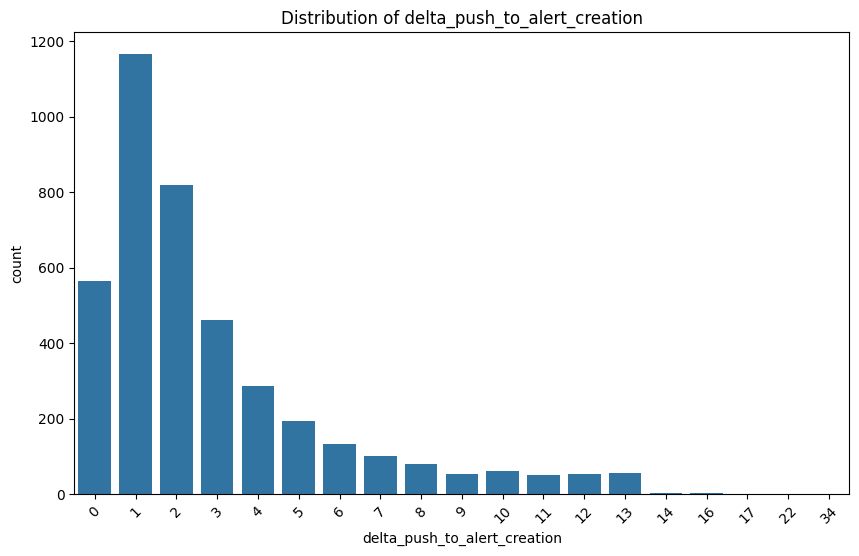

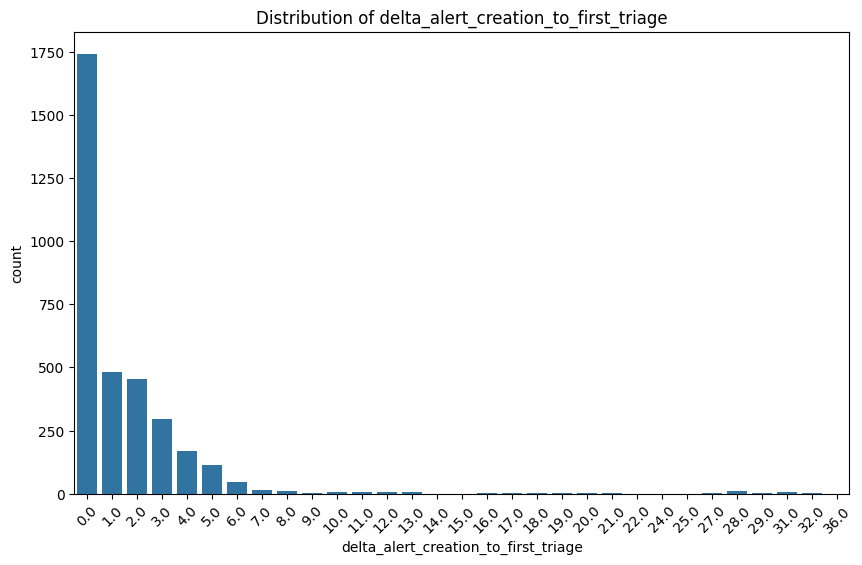

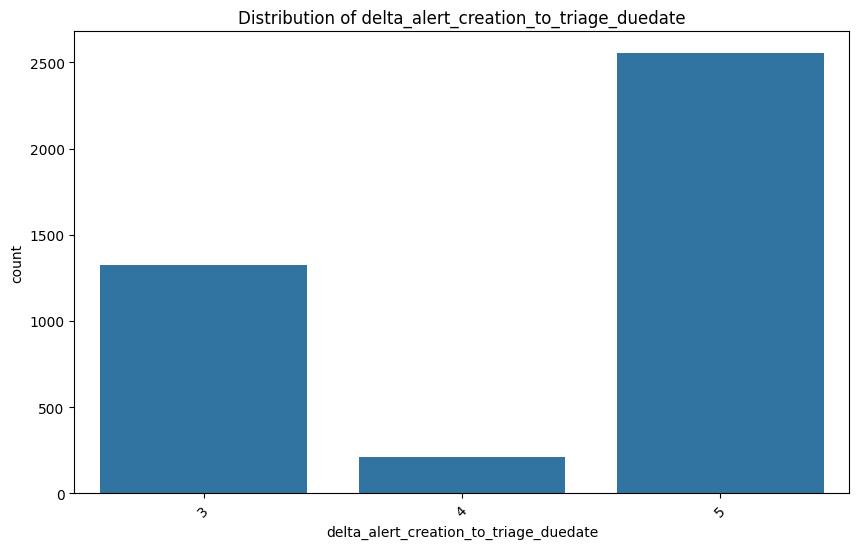

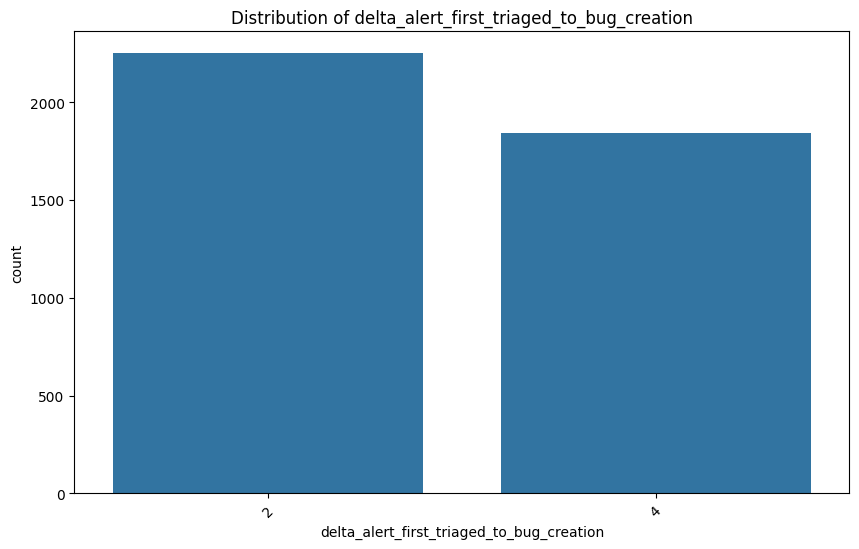

In [ ]:
get_dist_by_nb(alerts_df, delta_columns)

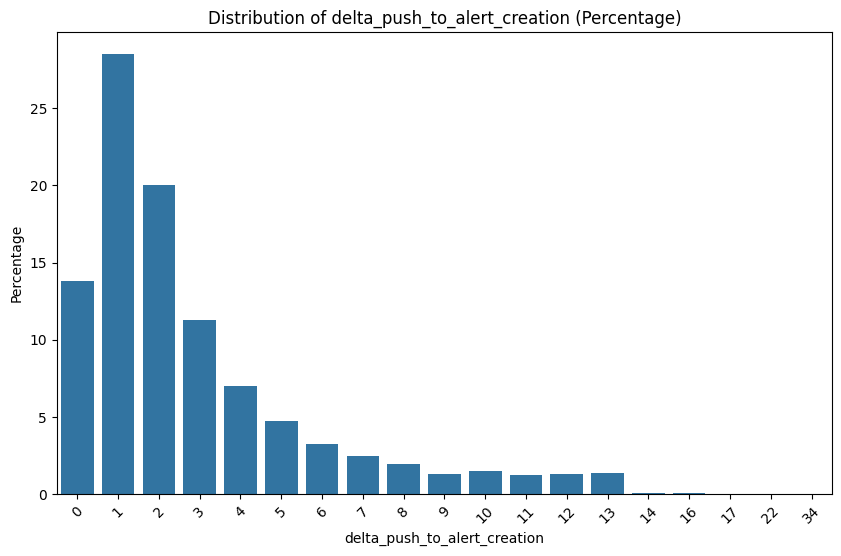

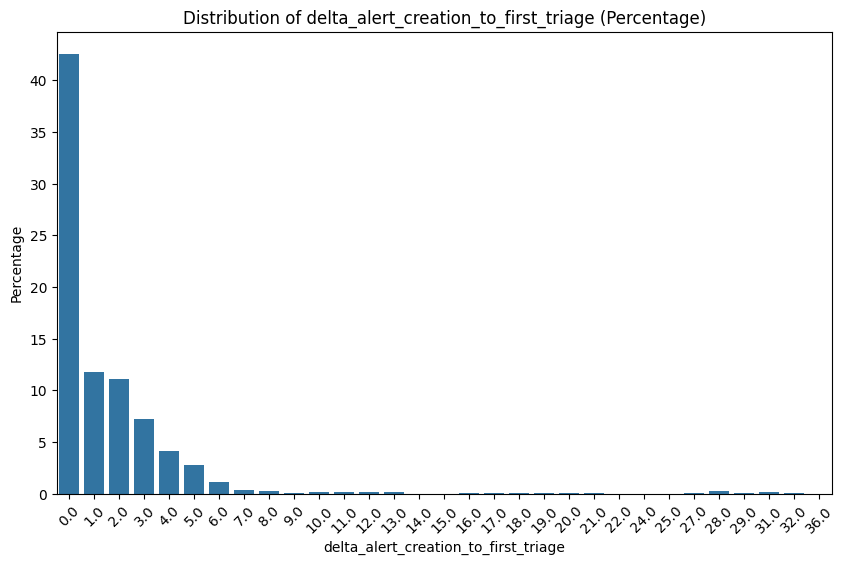

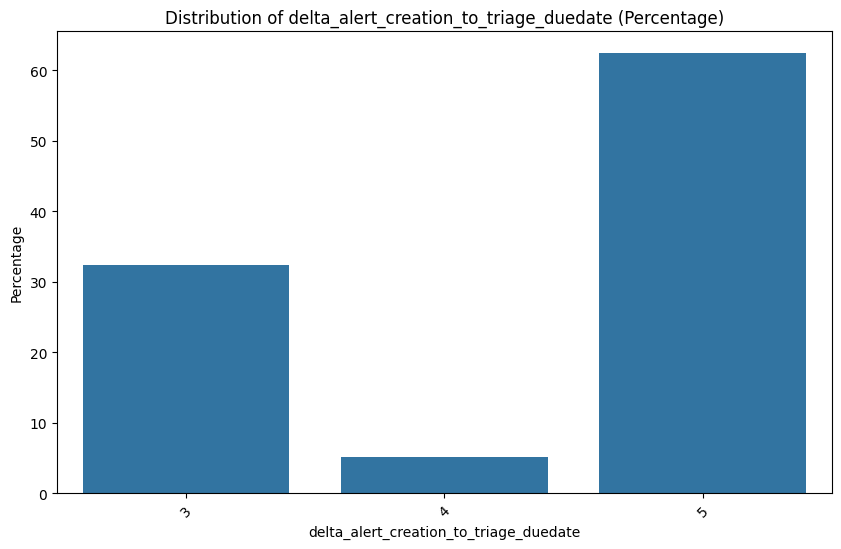

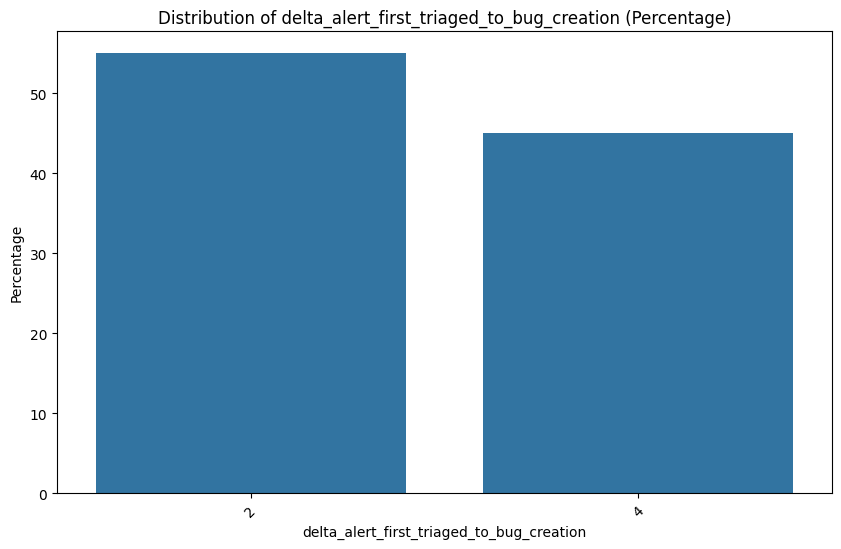

In [ ]:
get_dist_by_perc(alerts_df, delta_columns)

The following table presents the median and the mean of the time deltas for each framework

In [ ]:
result_mean = alerts_df.groupby('alert_framework')[delta_columns].mean()
result_median = alerts_df.groupby('alert_framework')[delta_columns].median()
result_table = pd.concat([result_mean, result_median], axis=1, keys=['Mean', 'Median']).round(2)
display(result_table)

Mean  \
                    delta_push_to_alert_creation   
alert_framework                                    
awsy                                        2.93   
browsertime                                 3.43   
build_metrics                               1.97   
devtools                                    2.23   
mozperftest                                 8.67   
platform_microbench                         2.02   
talos                                       3.30   

                                                          \
                    delta_alert_creation_to_first_triage   
alert_framework                                            
awsy                                                0.43   
browsertime                                         0.72   
build_metrics                                       1.01   
devtools                                            4.73   
mozperftest                                        10.67   
platform_microbench                                 0.50   
talos                                               0.98   

                                                            \
                    delta_alert_creation_to_triage_duedate   
alert_framework                                              
awsy                                                  4.11   
browsertime                                           4.35   
build_metrics                                         4.26   
devtools                                              4.38   
mozperftest                                           3.83   
platform_microbench                                   4.23   
talos                                                 4.18   

                                                               \
                    delta_alert_first_triaged_to_bug_creation   
alert_framework                                                 
awsy                                                     3.06   
browsertime                                              2.86   
build_metrics                                            2.84   
devtools                                                 2.89   
mozperftest                                              3.33   
platform_microbench                                      2.92   
talos                                                    3.04   

                                          Median  \
                    delta_push_to_alert_creation   
alert_framework                                    
awsy                                         3.0   
browsertime                                  2.0   
build_metrics                                1.0   
devtools                                     2.0   
mozperftest                                  3.5   
platform_microbench                          1.0   
talos                                        2.0   

                                                          \
                    delta_alert_creation_to_first_triage   
alert_framework                                            
awsy                                                 0.0   
browsertime                                          0.0   
build_metrics                                        0.0   
devtools                                             3.0   
mozperftest                                          9.5   
platform_microbench                                  0.5   
talos                                                0.0   

                                                            \
                    delta_alert_creation_to_triage_duedate   
alert_framework                                              
awsy                                                   5.0   
browsertime                                            5.0   
build_metrics                                          5.0   
devtools                                               5.0   
mozperftest                                            3.5   
platform_microbench             

In [ ]:
def get_dist_of_cat(dataf, col):
  df_copy = dataf.copy()
  col_counts = df_copy[col].value_counts(normalize=True) * 100
  plt.figure(figsize=(10, 6))
  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')
  plt.title('Percentage Distribution of Categories')
  plt.xlabel('Category')
  plt.ylabel('Percentage')
  plt.show()

<ipython-input-121-83dd845afd6b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


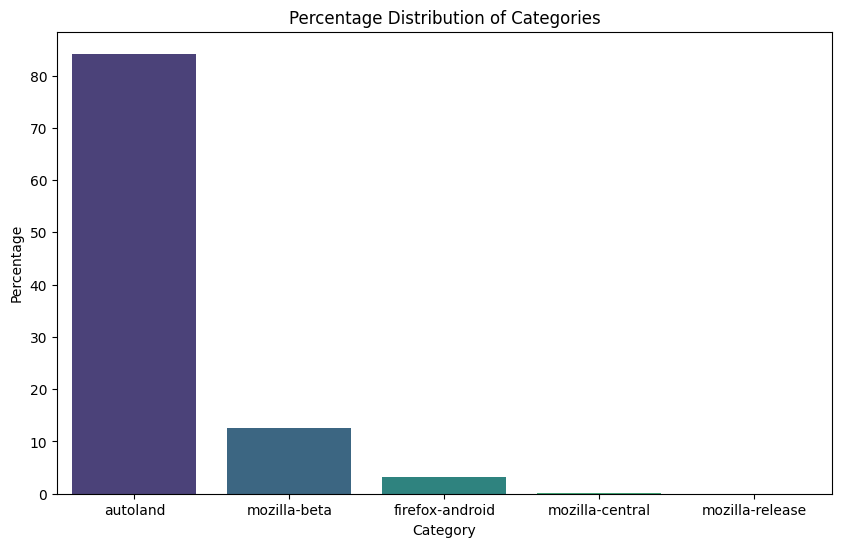

In [ ]:
get_dist_of_cat(alerts_df, 'alert_repository')

<ipython-input-121-83dd845afd6b>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


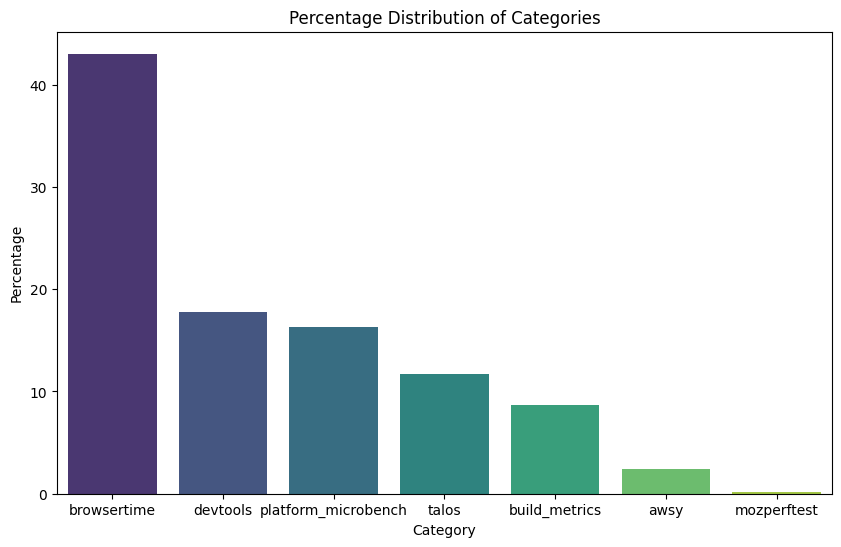

In [ ]:
get_dist_of_cat(alerts_df, 'alert_framework')

In [ ]:
'''timestamp1 = pd.Timestamp('2023-06-19 00:00:00')
timestamp2 = pd.Timestamp('2023-06-25 23:59:59')
print((dist_alerts_df[(dist_alerts_df.index >= timestamp1) & (dist_alerts_df.index <= timestamp2)]).shape)'''

"timestamp1 = pd.Timestamp('2023-06-19 00:00:00')\ntimestamp2 = pd.Timestamp('2023-06-25 23:59:59')\nprint((dist_alerts_df[(dist_alerts_df.index >= timestamp1) & (dist_alerts_df.index <= timestamp2)]).shape)"

On the following weekly classification, a given week spans from Monday at midnight to Sunday 11 PM 59 minutes and 59 seconds

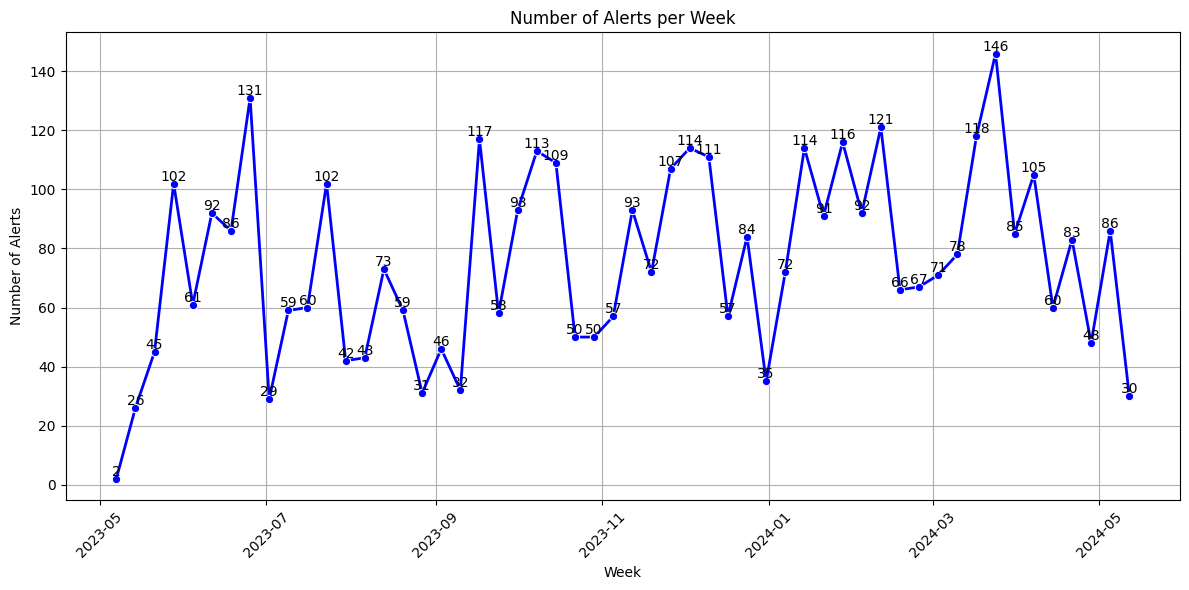

<Figure size 640x480 with 0 Axes>

In [ ]:
dist_alerts_df = alerts_df.copy()
dist_alerts_df.set_index('alert_creation_timestamp', inplace=True)

# Resample the data on a weekly basis and count the number of entries per week
weekly_entries = dist_alerts_df.resample('W').size()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_entries.index, y=weekly_entries.values, marker='o', color='blue', linewidth=2)
plt.title('Number of Alerts per Week')
plt.xlabel('Week')
plt.ylabel('Number of Alerts')
plt.xticks(rotation=45)
plt.grid(True)
for i, value in enumerate(weekly_entries.values):
    plt.text(weekly_entries.index[i], value, str(value), ha='center', va='bottom')
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

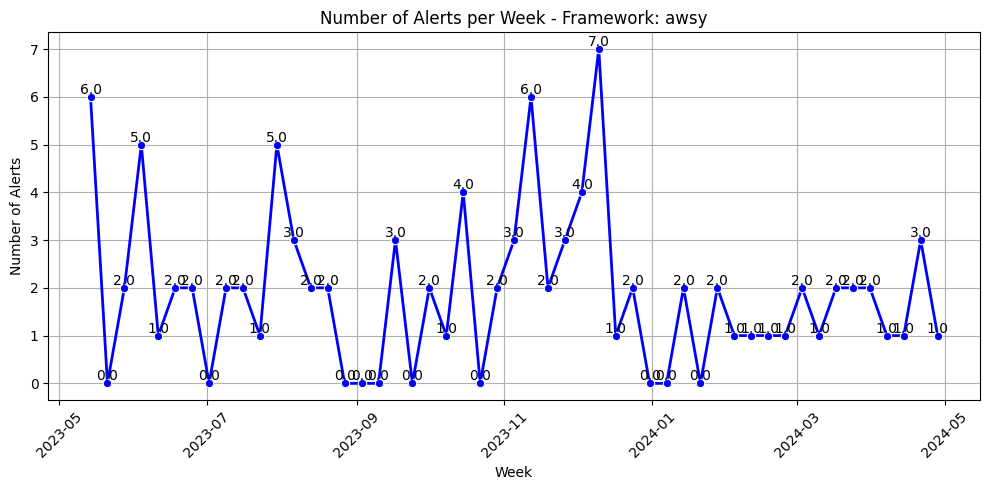

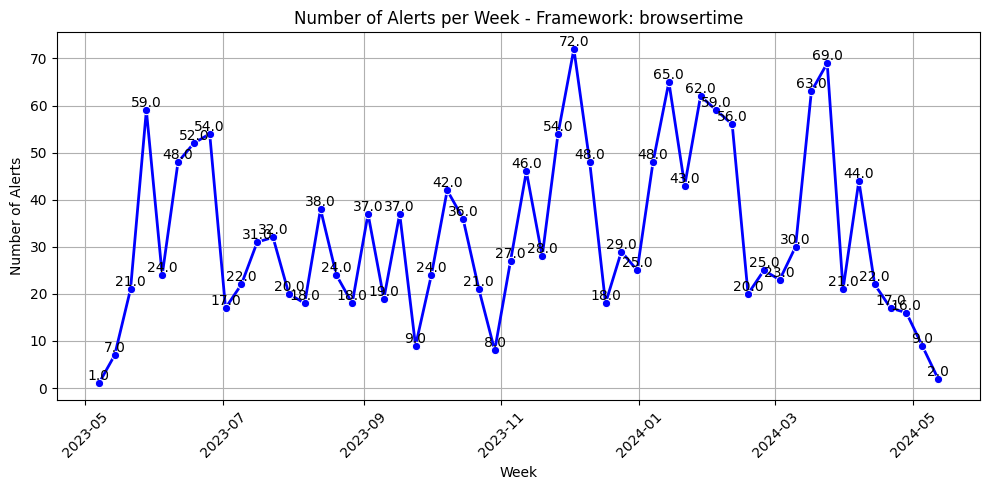

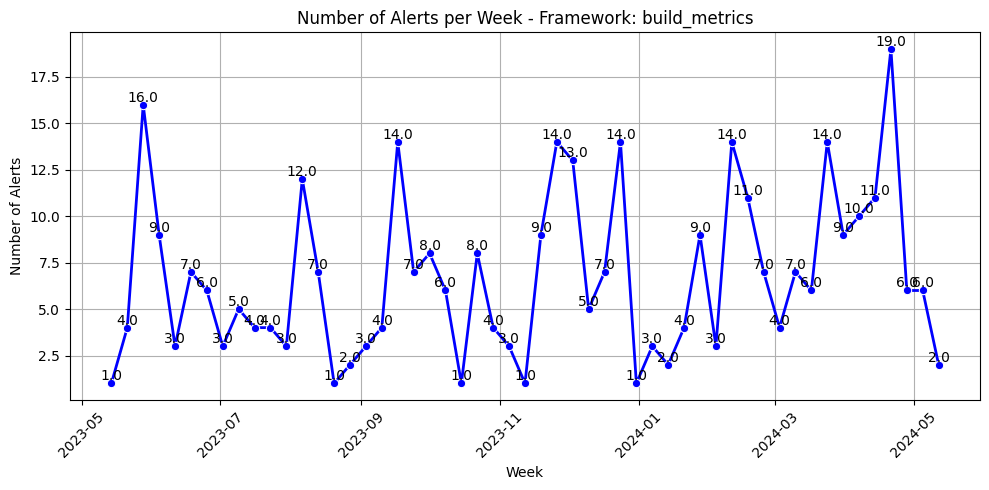

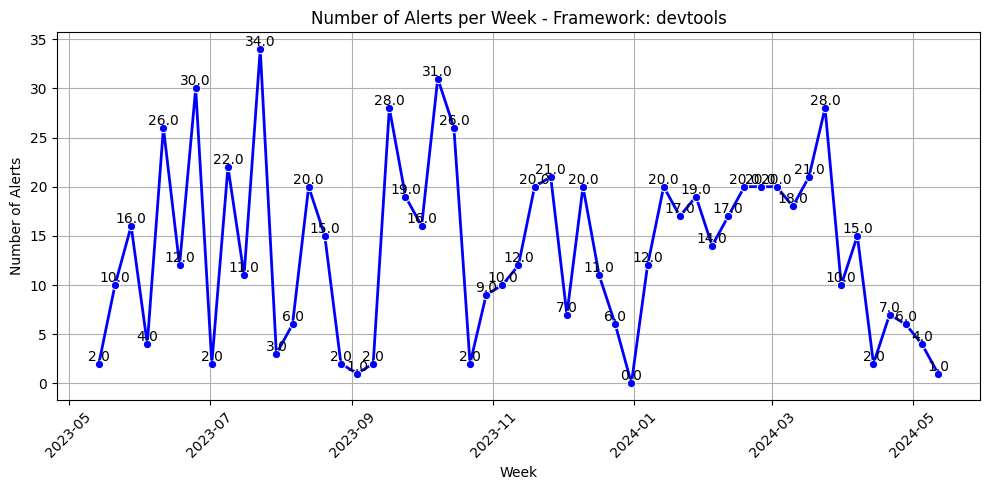

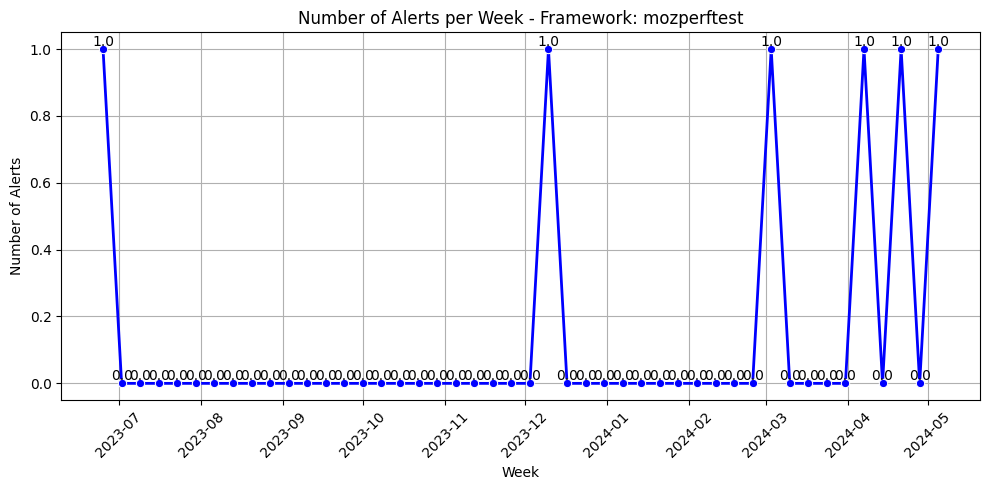

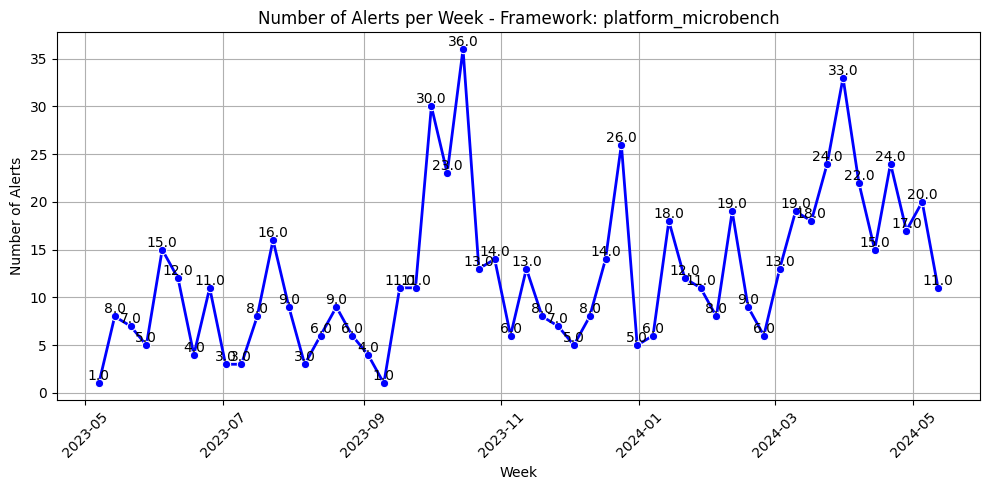

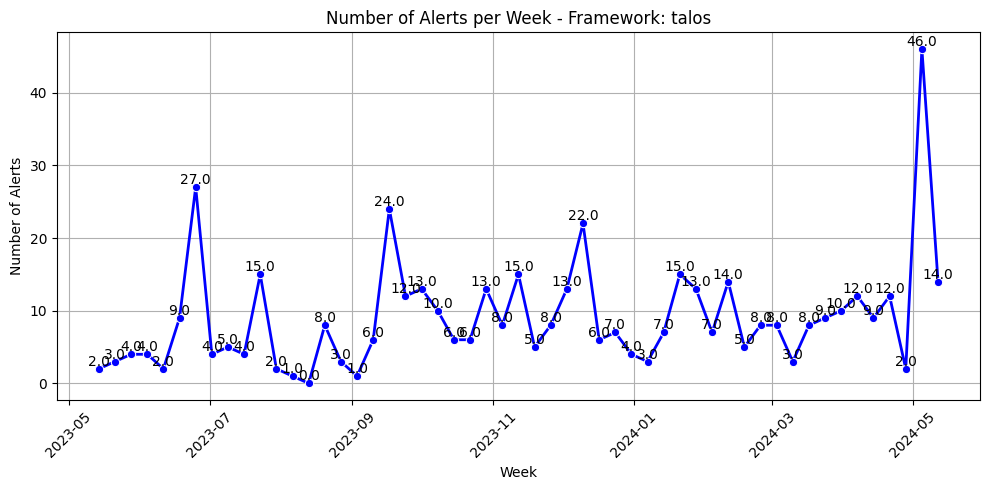

In [ ]:
weekly_entries_per_framework = dist_alerts_df.groupby(['alert_framework']).resample('W').size().unstack(level=0)

# Plotting
for framework in weekly_entries_per_framework.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=weekly_entries_per_framework[framework], marker='o', linewidth=2, color='blue')
    # Adding exact number of clients per data point
    for i, value in enumerate(weekly_entries_per_framework[framework]):
        plt.text(weekly_entries_per_framework.index[i], value, str(value), ha='center', va='bottom')
    plt.title(f'Number of Alerts per Week - Framework: {framework}')
    plt.xlabel('Week')
    plt.ylabel('Number of Alerts')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
nan_count = alerts_df['alert_bug_number'].isna().sum()
non_nan_count = alerts_df['alert_bug_number'].notna().sum()

print(f"Number of NaN elements in column '{'alert_bug_number'}': {nan_count}")
print(f"Number of non-NaN elements in column '{'alert_bug_number'}': {non_nan_count}")

Number of NaN elements in column 'alert_bug_number': 3429
Number of non-NaN elements in column 'alert_bug_number': 661


This means that out of 4090 alerts, only 661 alerts (correspondng to 16.1%) have associated bugs.
As far as understood, an alert gets triggered when there is a significant perfromance change. One of our goals is to find false positives meaning alerts that were triggered that are not improvement alerts but they're not regression alerts either. The following statuses are the ones that can be associated with a given alert :

- **untriaged** : these are the alerts that were not looked at by the performance team, so they are not classified, therefore it is impossible to detect their nature (false positives or not)
- **downstream** : Downstream alerts, as mentioned in the provided answer to the following question : "How can duplicate alerts can be identified?" in [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation, refer to alerts that are related to or affected by a particular original alert. Here's a simpler explanation:
Imagine you have an alert triggered by a specific issue, say a bug in a software component. This alert is the "original" alert. Now, downstream alerts are additional alerts that stem from or are related to this original alert.So, downstream alerts help to provide a more comprehensive view of the problem by capturing related issues or consequences of the original alert. It would make sense then to count them in as false positives as they are related to one change that propagates to different systems.
- **reassigned** : using common sense, these are alerts that were looked at, verdict was made about them, and then were decided to be looked at again, meaning they're still under investigation. Therefore they cannot be counted.
- **invalid** : looking at the answer for the question 'Do we care about all alerts/tests?' in [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation, the invalid alerts seem to be due to noise, making them false positives
- **improvement** : these are labeled improvements so they will be excluded from the count
- **investigating** : these ones trivially are alerts still under investigation, therefore they will not be taken into consideration
- **wontfix** : Looking at [this](https://bugzilla.mozilla.org/show_bug.cgi?id=1886674) and [this](https://bugzilla.mozilla.org/show_bug.cgi?id=1886163) bugs, 'wontfix' seems to represent false positives that do report alerts that shouldn't be triggered or were triggered for the wrong reasons
- **fixed** : this one trivially means that the issue triggered through the alert is fixed. Logically speaking, an improvement in performance does not lead to a fix nor a false positive alert does so. The only possibility is that this is a fixed regression, therefore this one will be considered a false positive
- **backedout** : As far as understood from [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation (answering the What is a backout? question), it seems that 'backedout' implies that a given alert ended up with rollbacking the changes, which logically means that the push caused a regression that lead to the rollback. Therefore, this one will be considered as a true positive regression

In summary, untriaged, reassigned, investigating, and improvement alerts are not considered into determining false positive regressions. The alerts associated with downstream, invalid, wontfix, fixed, and backedout statuses are considered for the investigation, where the first three representing the false positives.

In [ ]:
fp_inv_df = alerts_df.copy()
fp_inv_df = fp_inv_df[~fp_inv_df['alert_status'].isin(["investigating", "untriaged", "downstream"])]

In [ ]:
def calculate_category_percentage(dataf, category_column, categories):
    total_rows = len(dataf)
    category_counts = dataf[dataf[category_column].isin(categories)].groupby(category_column).size()
    percentage_dict = {category: (count / total_rows) * 100 for category, count in category_counts.items()}
    return percentage_dict

categories_of_interest = ["improvement", "invalid", "wontfix", "fixed", "backedout", "reassigned"]

# Calculate the percentage for each category
percentage_dict = calculate_category_percentage(fp_inv_df, 'alert_status', categories_of_interest)


#fp = 0
for category, percentage in percentage_dict.items():
    print(f"Percentage of rows with category '{category}': {percentage:.2f}%")
'''
    if category in ["invalid", "wontfix"]:
      fp += percentage
'''
print("Percentage of False Positives: " + str(percentage_dict["invalid"]) + "%")

Percentage of rows with category 'backedout': 0.93%
Percentage of rows with category 'fixed': 6.44%
Percentage of rows with category 'improvement': 47.34%
Percentage of rows with category 'invalid': 34.53%
Percentage of rows with category 'wontfix': 10.76%
Percentage of False Positives: 45.2855245683931%


In [ ]:
df_alerts_bugs = alerts_df[alerts_df['alert_bug_number'].notna()]
print(df_alerts_bugs.shape)
df_alerts_bugs = df_alerts_bugs[df_alerts_bugs['alert_status'].isin(["improvement", "fixed", "backedout"])]
print(df_alerts_bugs.shape)
display(df_alerts_bugs.head(5))

(661, 25)
(312, 25)


alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
178        74        1417496             1417475 2024-05-03 18:16:39.426431   
436        25        1416664             1416661 2024-04-29 07:35:42.790226   
450        16        1410269             1410263 2024-04-26 13:31:27.734956   
451        15        1409812             1409803 2024-04-26 13:29:00.569284   
458         8        1413921             1413770 2024-04-25 15:21:43.752708   

           alert_first_triaged      alert_triage_due_date alert_repository  \
178 2024-05-03 18:16:39.818030 2024-05-08 18:16:39.426431         autoland   
436 2024-04-29 07:35:43.115101 2024-05-02 07:35:42.790226         autoland   
450 2024-04-26 13:31:27.905310 2024-05-01 13:31:27.734956         autoland   
451 2024-04-26 13:29:00.709729 2024-05-01 13:29:00.569284         autoland   
458 2024-04-29 07:31:14.185105 2024-04-30 15:21:43.752708         autoland   

    alert_framework                         alert_related_alerts alert_status  \
178           talos                                    |231|207|  improvement   
436        devtools                          |33|31|32|34|35|36|  improvement   
450           talos  |193432|193436|193437|193431|193544|193532|  improvement   
451           talos                       |193403|193422|193394|  improvement   
458        devtools                                          NaN  improvement   

     alert_bug_number         alert_bug_due_date          alert_bug_updated  \
178         1893789.0 2024-05-10 18:16:39.426431 2024-05-08 10:42:01.880978   
436         1890552.0 2024-05-06 07:35:42.790226 2024-04-29 07:38:36.772737   
450         1888748.0 2024-05-03 13:31:27.734956 2024-04-26 14:02:22.120184   
451         1888628.0 2024-05-03 13:29:00.569284 2024-04-26 14:15:03.853915   
458         1888607.0 2024-05-02 15:21:43.752708 2024-04-29 07:31:14.185205   

     alert_issue_tracker alert_notes  \
178                    1         NaN   
436                    1         NaN   
450                    1         NaN   
451                    1         NaN   
458                    1         NaN   

                               alert_revision alert_push_timestamp  \
178  390e86921c53a6af7280bf83e3b5d485759283e0  2024-04-29 08:18:35   
436  4ae03cc6083fd67592b64b259a4bfad4e7d3ace9  2024-04-26 09:21:41   
450  d06a0d7b341361ec7d0e996636f94a7ebd68b92e  2024-04-17 06:10:00   
451  3b76cb83627af4607b79caf70a03243e6ee6369b  2024-04-16 16:29:24   
458  d0b5d121d8fc8ffddbec3e026a455ecfe0071347  2024-04-23 11:54:58   

                     alert_prev_push_revision  \
178  91f7d54aead75a56e132425fa8f764467138d322   
436  f10daac4c929c07fb9eb03cafd28130854277869   
450  54882b6de6ac255482abf21e352f2337a1317d3f   
451  6c6258954d92b34174ed0fb95bb92107a5c602ad   
458  5519716422b3e14060894caded45bac7a3aeb773   

                  alert_assignee_username     alert_assignee_email  \
178  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   
436                                   NaN                      NaN   
450      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
451      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
458                                   NaN                      NaN   

    alert_performance_tags  delta_push_to_alert_creation  \
178                    NaN                             4   
436                    NaN                             2   
450            improvement                             9   
451            improvement                             9   
458                    NaN                             2   

     delta_alert_creation_to_first_triage  \
178                                   0.0   
436                                   0.0   
450                                   0.0   
451                                   0.0   
458                                   3.0   

     delta_alert_creation_to_triage_duedate  \
178                                       

In [ ]:
df_alerts_bugs.rename(columns={'alert_bug_number': 'bug_id'}, inplace=True)
df_alerts_bugs["bug_id"] = df_alerts_bugs["bug_id"].astype(int)

In [ ]:
print(df_alerts_bugs.shape)

(312, 25)


# Bugs data analysis

In [ ]:
df_bugs = pd.read_csv('/content/aabugs_data.csv', index_col=False)

In [ ]:
display(df_bugs.head(5))

bug_id bug_resolution     bug_type      bug_component  \
0  1171441          FIXED       defect          Web Audio   
1  1800641          FIXED         task  JavaScript Engine   
2  1812589          FIXED         task             Raptor   
3  1814798          FIXED  enhancement   Memory Allocator   
4  1819275          FIXED       defect     Graphics: Text   

                                         bug_summary bug_classification  \
0  Add a way to determine if an AudioParam is con...         Components   
1  Move value-like fields of ScriptLoadRequest in...         Components   
2  Ensure the CPU frequency, and other optimizati...         Components   
3                  Allow PHC to be enabled by a pref         Components   
4  [macOS] Attempt to avoid the main thread being...         Components   

  bug_status     bug_creation_time bug_url  bug_last_change_time bug_severity  \
0   RESOLVED  2015-06-04T13:39:53Z     NaN  2023-09-28T13:43:42Z           S3   
1   RESOLVED  2022-11-15T14:10:21Z     NaN  2024-01-16T13:35:09Z          NaN   
2   RESOLVED  2023-01-26T13:36:00Z     NaN  2023-09-02T15:35:04Z           S2   
3   RESOLVED  2023-02-03T02:57:55Z     NaN  2023-11-22T19:45:14Z           --   
4   RESOLVED  2023-02-28T09:42:14Z     NaN  2023-10-03T14:00:42Z           S3   

  bug_priority bug_product  bug_is_confirmed  bug_votes  bug_is_open  \
0           P3        Core              True          0        False   
1           P1        Core              True          0        False   
2           P1     Testing              True          0        False   
3           P2        Core              True          0        False   
4           --        Core              True          0        False   

                 bug_assigned_to  bug_cf_last_resolved  \
0        karlt@mozbugz.karlt.net  2023-09-23T09:27:24Z   
1  nicolas.b.pierron@mozilla.com  2024-01-08T21:34:42Z   
2            aglavic@mozilla.com  2023-06-20T21:29:37Z   
3              pbone@mozilla.com  2023-09-18T14:50:03Z   
4             jfkthame@gmail.com  2023-09-27T03:55:10Z   

  bug_cf_performance_impact  bug_version bug_whiteboard bug_platform  \
0                       ---  unspecified            NaN  Unspecified   
1                       ---  unspecified            NaN  Unspecified   
2                       NaN  unspecified          [fxp]  Unspecified   
3                       ---  unspecified            NaN          All   
4                       ---  unspecified            NaN  Unspecified   

       bug_keywords  IsPerformanceBug  
0  perf, perf-alert             False  
1        perf-alert             False  
2        perf-alert             False  
3        perf-alert             False  
4               NaN             False

In [ ]:
bugs_datetime_cols = ["bug_creation_time", "bug_last_change_time", "bug_cf_last_resolved"]
for i in bugs_datetime_cols:
  df_bugs[i] = pd.to_datetime(df_bugs[i], format='%Y-%m-%dT%H:%M:%SZ')

In [ ]:
a1 = set(df_alerts_bugs["bug_id"].unique())
a2 = set(df_bugs["bug_id"].unique())
print("Number of non-performance bugs associated with performance alerts :")
print(len(a1 - a2))
print("Non-performance bugs associated with performance alerts :")
print(a1 - a2)

Number of non-performance bugs associated with performance alerts :
0
Non-performance bugs associated with performance alerts :
set()


In [ ]:
df_alerts_bugs = pd.merge(df_alerts_bugs, df_bugs, on='bug_id', how='inner')

In [ ]:
print("Number of alerts with asociated performance bugs")
print(df_alerts_bugs.shape[0])

Number of alerts with asociated performance bugs
312


In [ ]:
display(df_alerts_bugs.head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0        74        1417496             1417475 2024-05-03 18:16:39.426431   
1        25        1416664             1416661 2024-04-29 07:35:42.790226   
2        16        1410269             1410263 2024-04-26 13:31:27.734956   
3        15        1409812             1409803 2024-04-26 13:29:00.569284   
4         8        1413921             1413770 2024-04-25 15:21:43.752708   

         alert_first_triaged      alert_triage_due_date alert_repository  \
0 2024-05-03 18:16:39.818030 2024-05-08 18:16:39.426431         autoland   
1 2024-04-29 07:35:43.115101 2024-05-02 07:35:42.790226         autoland   
2 2024-04-26 13:31:27.905310 2024-05-01 13:31:27.734956         autoland   
3 2024-04-26 13:29:00.709729 2024-05-01 13:29:00.569284         autoland   
4 2024-04-29 07:31:14.185105 2024-04-30 15:21:43.752708         autoland   

  alert_framework                         alert_related_alerts alert_status  \
0           talos                                    |231|207|  improvement   
1        devtools                          |33|31|32|34|35|36|  improvement   
2           talos  |193432|193436|193437|193431|193544|193532|  improvement   
3           talos                       |193403|193422|193394|  improvement   
4        devtools                                          NaN  improvement   

    bug_id         alert_bug_due_date          alert_bug_updated  \
0  1893789 2024-05-10 18:16:39.426431 2024-05-08 10:42:01.880978   
1  1890552 2024-05-06 07:35:42.790226 2024-04-29 07:38:36.772737   
2  1888748 2024-05-03 13:31:27.734956 2024-04-26 14:02:22.120184   
3  1888628 2024-05-03 13:29:00.569284 2024-04-26 14:15:03.853915   
4  1888607 2024-05-02 15:21:43.752708 2024-04-29 07:31:14.185205   

   alert_issue_tracker alert_notes                            alert_revision  \
0                    1         NaN  390e86921c53a6af7280bf83e3b5d485759283e0   
1                    1         NaN  4ae03cc6083fd67592b64b259a4bfad4e7d3ace9   
2                    1         NaN  d06a0d7b341361ec7d0e996636f94a7ebd68b92e   
3                    1         NaN  3b76cb83627af4607b79caf70a03243e6ee6369b   
4                    1         NaN  d0b5d121d8fc8ffddbec3e026a455ecfe0071347   

  alert_push_timestamp                  alert_prev_push_revision  \
0  2024-04-29 08:18:35  91f7d54aead75a56e132425fa8f764467138d322   
1  2024-04-26 09:21:41  f10daac4c929c07fb9eb03cafd28130854277869   
2  2024-04-17 06:10:00  54882b6de6ac255482abf21e352f2337a1317d3f   
3  2024-04-16 16:29:24  6c6258954d92b34174ed0fb95bb92107a5c602ad   
4  2024-04-23 11:54:58  5519716422b3e14060894caded45bac7a3aeb773   

                alert_assignee_username     alert_assignee_email  \
0  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   
1                                   NaN                      NaN   
2      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
3      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
4                                   NaN                      NaN   

  alert_performance_tags  delta_push_to_alert_creation  \
0                    NaN                             4   
1                    NaN                             2   
2            improvement                             9   
3            improvement                             9   
4                    NaN                             2   

   delta_alert_creation_to_first_triage  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   3.0   

   delta_alert_creation_to_triage_duedate  \
0                                       5   
1                                       3   
2                                       5   
3                                       5   
4                                       5   

   delta_alert_first_

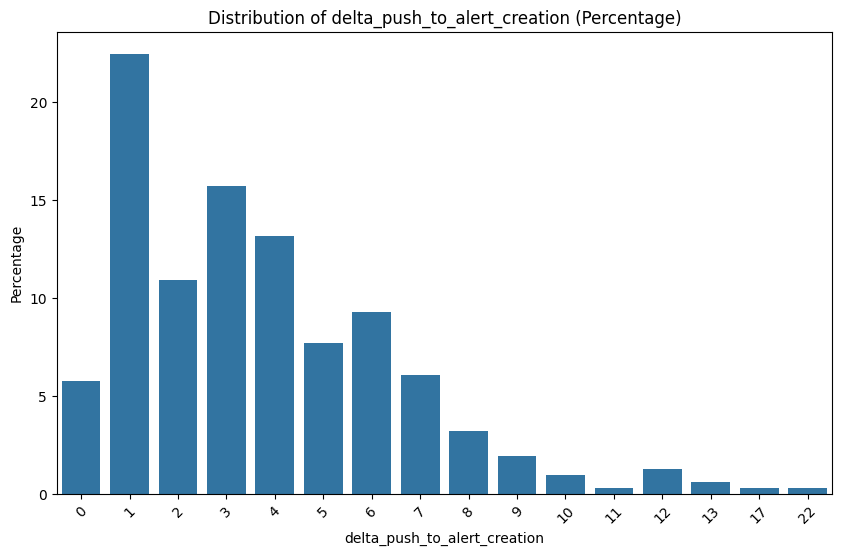

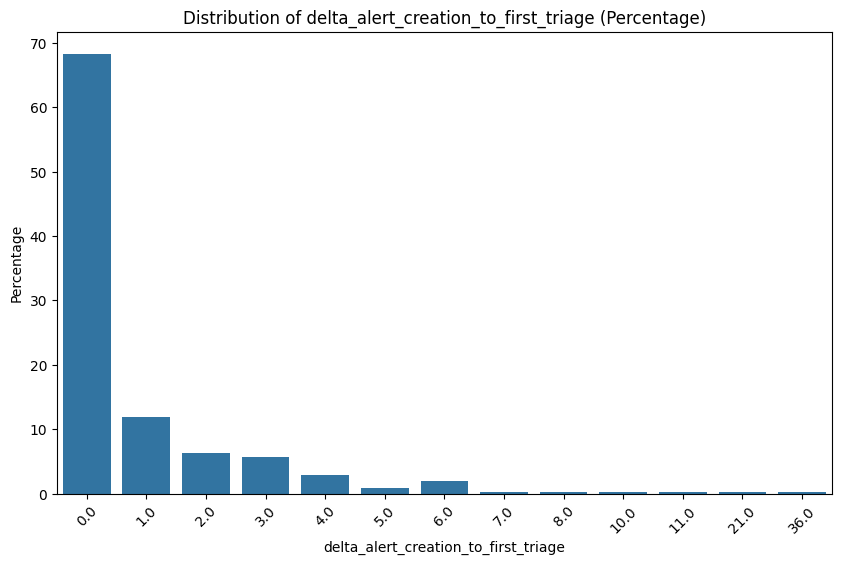

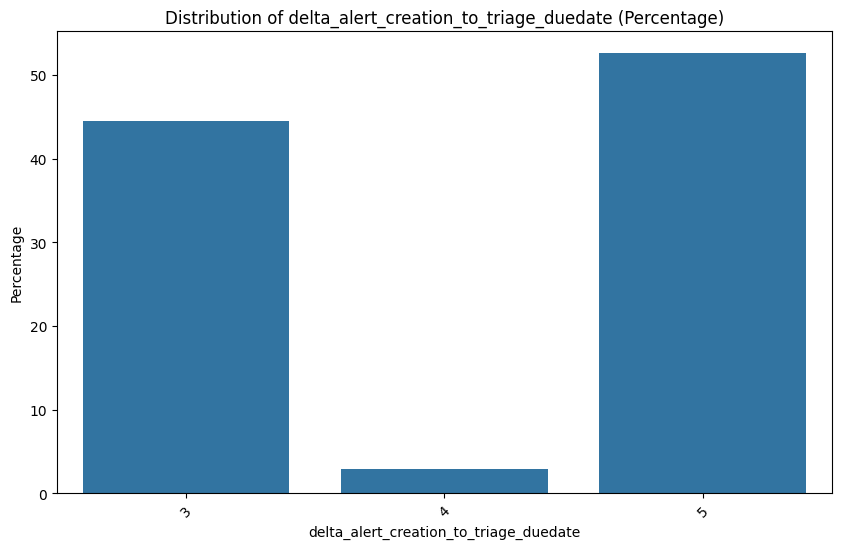

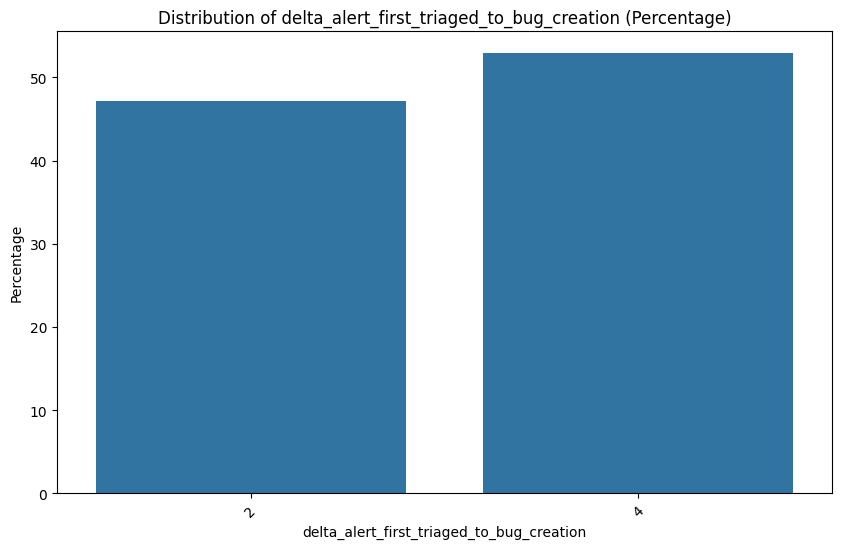

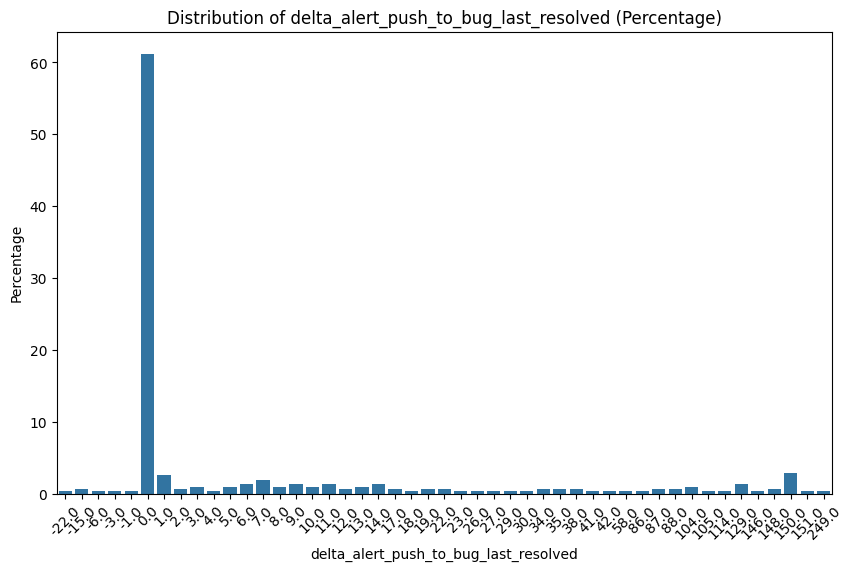

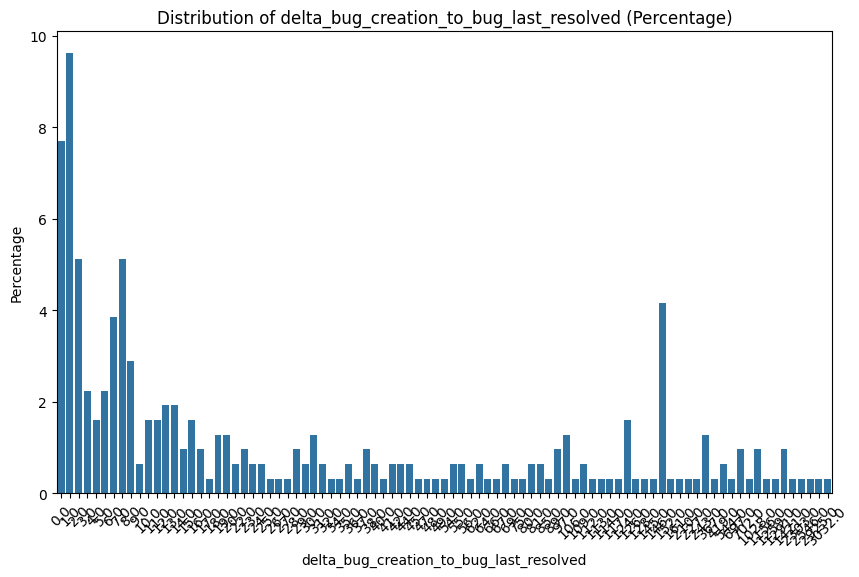

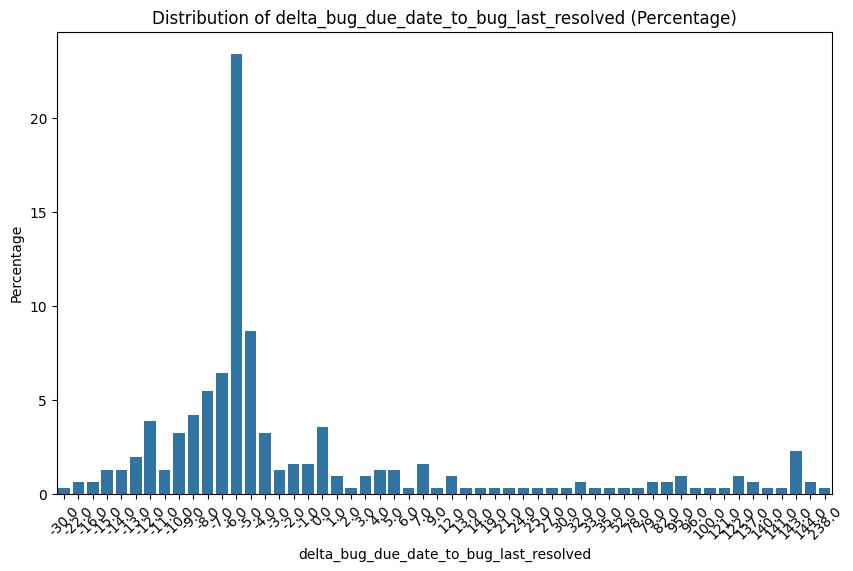

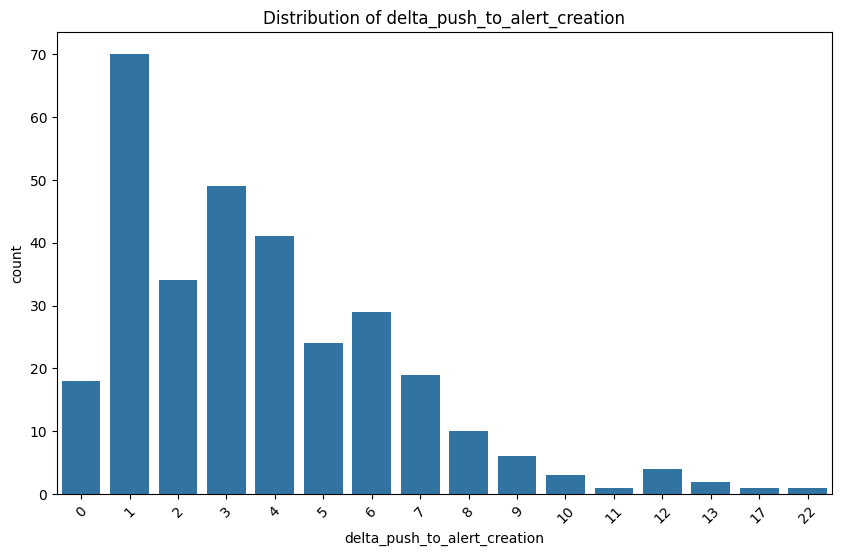

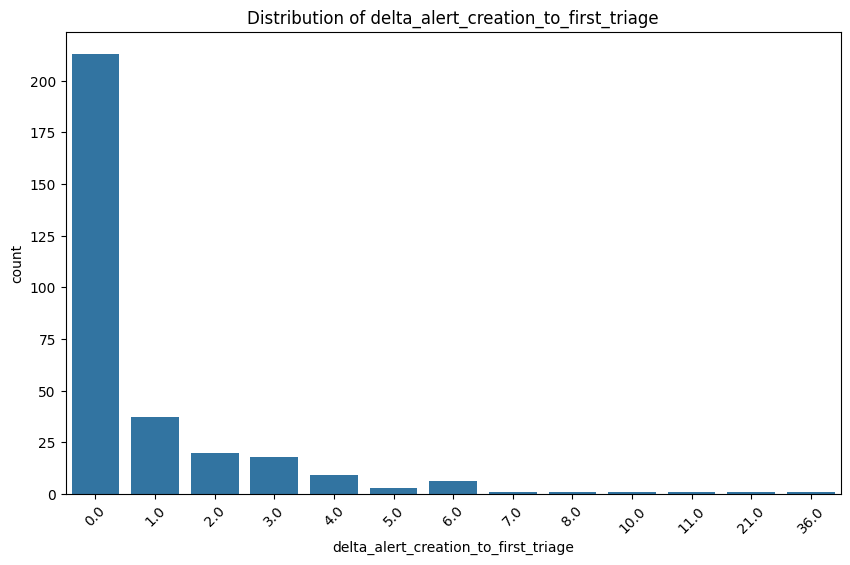

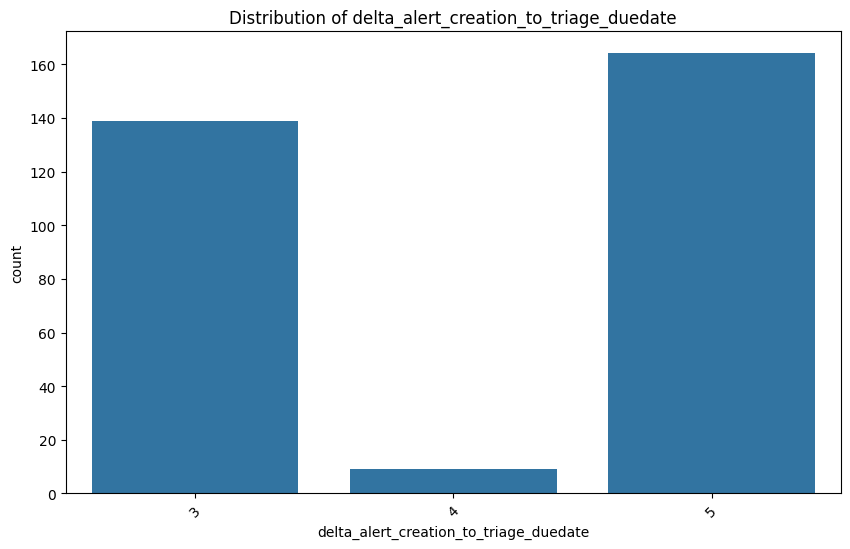

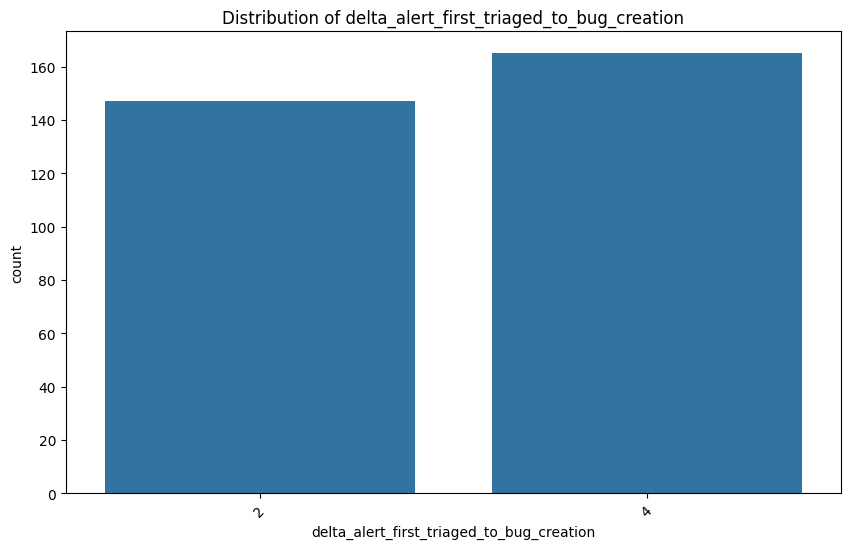

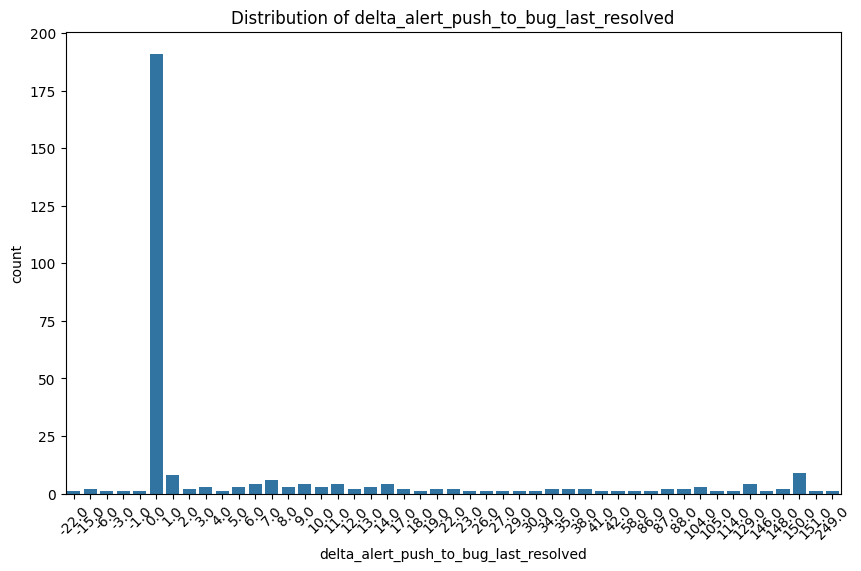

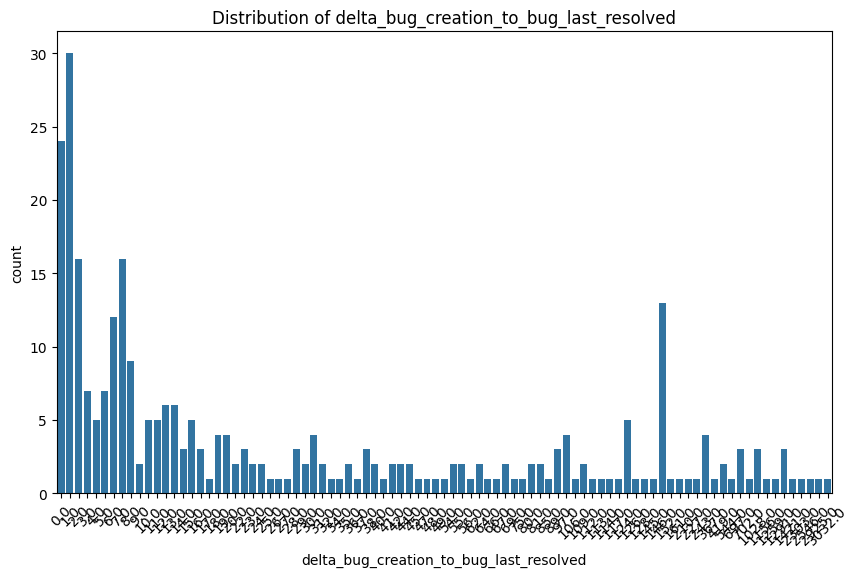

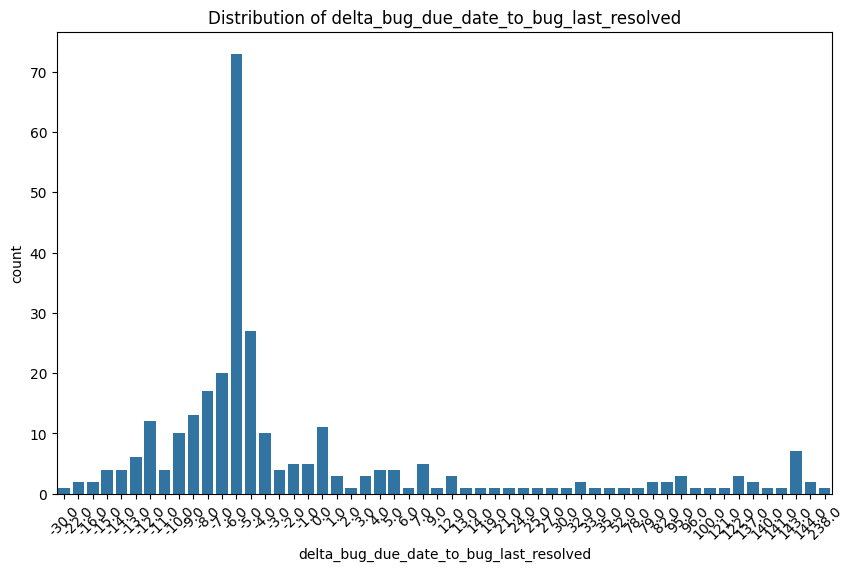

In [ ]:
delta_columns_extension = ["delta_alert_push_to_bug_last_resolved", "delta_bug_creation_to_bug_last_resolved", "delta_bug_due_date_to_bug_last_resolved"]
delta_columns_extended = delta_columns + delta_columns_extension
subtract_cols(df_alerts_bugs, "delta_alert_push_to_bug_last_resolved", "bug_cf_last_resolved", "alert_push_timestamp")
subtract_cols(df_alerts_bugs, "delta_alert_creation_to_bug_last_resolved", "bug_cf_last_resolved", "alert_creation_timestamp")
subtract_cols(df_alerts_bugs, "delta_bug_creation_to_bug_last_resolved", "bug_cf_last_resolved", "bug_creation_time")
subtract_cols(df_alerts_bugs, "delta_bug_due_date_to_bug_last_resolved", "bug_cf_last_resolved", "alert_triage_due_date")
get_dist_by_perc(df_alerts_bugs, delta_columns_extended)
get_dist_by_nb(df_alerts_bugs, delta_columns_extended)

In [ ]:
print("Average time between pushing code that causes a performance change to its detection (in days)")
print(df_alerts_bugs["delta_push_to_alert_creation"].mean())
print("Average time between creating a bug related to a performance alert and its first triage (in days)")
print(df_alerts_bugs["delta_alert_creation_to_first_triage"].mean())
print("Maedian time between creating a bug relared to a performance alert and resolving this bug")
print(df_alerts_bugs["delta_bug_creation_to_bug_last_resolved"].median())

Average time between pushing code that causes a performance change to its detection (in days)
3.730769230769231
Average time between creating a bug related to a performance alert and its first triage (in days)
0.9967948717948718
Maedian time between creating a bug relared to a performance alert and resolving this bug
13.0


Note that the median is used for the mast metric because some outliers are causing the average time to be more than 100 days, that is why the median value is provided

In [ ]:
display(df_alerts_bugs[df_alerts_bugs["delta_bug_creation_to_bug_last_resolved"] > 2000].head(2))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
59      41510        1377375             1377304 2024-02-19 23:12:24.349588   
196     39828        1311016             1310989 2023-10-06 11:58:01.938143   

           alert_first_triaged      alert_triage_due_date alert_repository  \
59  2024-02-20 06:13:52.922618 2024-02-22 23:12:24.349588         autoland   
196 2023-10-09 09:25:22.640086 2023-10-11 11:58:01.938143         autoland   

    alert_framework    alert_related_alerts alert_status   bug_id  \
59         devtools         |189904|189918|  improvement  1247751   
196           talos  |181708|181742|181748|  improvement  1310170   

            alert_bug_due_date          alert_bug_updated  \
59  2024-02-26 23:12:24.349588 2024-02-20 06:19:38.862766   
196 2023-10-13 11:58:01.938143 2023-10-09 12:29:00.384660   

     alert_issue_tracker alert_notes  \
59                     1         NaN   
196                    1         NaN   

                               alert_revision alert_push_timestamp  \
59   2b4e9ee6225f1183da45d24404e72f48e3803f08  2024-02-15 12:49:34   
196  66d921932ca7cf275d17bf4942aa92a9b9ef9f9d  2023-10-04 13:30:18   

                     alert_prev_push_revision  \
59   aa5fc411278d3beae081682cb31a2167257d3aed   
196  7a7e10acc67d83c1b5d36bd0951bd37d1f7904a9   

                  alert_assignee_username     alert_assignee_email  \
59                                    NaN                      NaN   
196  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   

    alert_performance_tags  delta_push_to_alert_creation  \
59                     NaN                             4   
196            improvement                             1   

     delta_alert_creation_to_first_triage  \
59                                    0.0   
196                                   2.0   

     delta_alert_creation_to_triage_duedate  \
59                                        3   
196                                       5   

     delta_alert_first_triaged_to_bug_creation bug_resolution     bug_type  \
59                                           4          FIXED       defect   
196                                          2          FIXED  enhancement   

                   bug_component  \
59              Inspector: Rules   
196  CSS Parsing and Computation   

                                           bug_summary bug_classification  \
59   rule view hangs for a long time when there are...         Components   
196                     Implement 'lh' and 'rlh' units         Components   

    bug_status   bug_creation_time  \
59    RESOLVED 2016-02-11 22:14:55   
196   RESOLVED 2016-10-14 12:59:37   

                                               bug_url bug_last_change_time  \
59                                                 NaN  2024-03-23 03:16:19   
196  https://drafts.csswg.org/css-values-3/#font-re...  2023-11-16 13:15:39   

    bug_severity bug_priority bug_product  bug_is_confirmed  bug_votes  \
59            S3           P2    DevTools              True          1   
196           S3           P3        Core              True          5   

     bug_is_open        bug_assigned_to bug_cf_last_resolved  \
59         False  nchevobbe@mozilla.com  2024-02-15 21:03:25   
196        False      dshin@mozilla.com  2023-10-05 03:55:57   

    bug_cf_performance_impact  bug_version    bug_whiteboard bug_platform  \
59                        ---  unspecified  [btpp-fix-later]  Unspecified   
196                       ---        Trunk               NaN          All   

                                          bug_keywords  IsPerformanceBug  \
59                                                 NaN             False   
196  dev-doc-complete, parity-chrome, parity-safari...             False   

     delta_alert_push_to_bug_last_resolved  \
59                                     0.0   
196                                    0.0   

     delta_alert_creation_to_bug_last_resolve

In [ ]:
df_alerts_bugs["delta_alert_creation_to_first_triage"] = df_alerts_bugs["delta_alert_creation_to_first_triage"].fillna(pd.NA)
df_alerts_bugs["delta_alert_creation_to_first_triage"] = pd.to_numeric(df_alerts_bugs["delta_alert_creation_to_first_triage"], errors='coerce').astype('Int64')

In [ ]:
'''plt.figure(figsize=(10, 6))
sns.barplot(data=df_alerts_bugs, x="delta_alert_creation_to_first_triage", y="delta_alert_creation_to_first_triage", estimator=lambda x: len(x) / len(aa) * 100)
plt.title(f'Distribution of time between alert creation and its first triage')
plt.ylabel('Percentage')
plt.xlabel('Alert creation to its first triage (in days)')
plt.xticks(rotation=45)
plt.show()'''

'plt.figure(figsize=(10, 6))\nsns.barplot(data=df_alerts_bugs, x="delta_alert_creation_to_first_triage", y="delta_alert_creation_to_first_triage", estimator=lambda x: len(x) / len(aa) * 100)\nplt.title(f\'Distribution of time between alert creation and its first triage\')\nplt.ylabel(\'Percentage\')\nplt.xlabel(\'Alert creation to its first triage (in days)\')\nplt.xticks(rotation=45)\nplt.show()'

[This](https://firefox-source-docs.mozilla.org/testing/perfdocs/perf-sheriffing.html) documentation states that all of the performance sheriffing team is in EET (Eastern European Time: UTC+2) except for @andrej and @sparky who are in EST (Eastern Standard Time: UTC-5). Assuming that teams work everyday from 9 AM to 6 PM from Monday to Friday, the work hours for the performance sheriffing team spans from Monday to Friday between 7 AM to 11 PM.

In [ ]:
def mask(dataf, timestamp_column):
  mask = ((dataf[timestamp_column].dt.dayofweek >= 0) & (dataf[timestamp_column].dt.dayofweek <= 4) &
        (dataf[timestamp_column].dt.hour >= 7) & (dataf[timestamp_column].dt.hour < 23))
  return mask

In [ ]:
testdf = df_alerts_bugs.copy()

In [ ]:
print(testdf.shape)

(312, 52)


In [ ]:
'''testdf = testdf[mask(testdf, "bug_cf_last_resolved")]
testdf = testdf[mask(testdf, "alert_push_timestamp")]
testdf = testdf[mask(testdf, "alert_creation_timestamp")]
testdf = testdf[mask(testdf, "alert_triage_due_date")]
'''
testdf.dropna(subset=['bug_cf_last_resolved', 'alert_creation_timestamp', 'alert_push_timestamp', 'alert_triage_due_date'], inplace=True)
subtract_cols_hours(testdf, "delta_alert_push_to_bug_last_resolved", "bug_cf_last_resolved", "alert_push_timestamp")
subtract_cols_hours(testdf, "delta_alert_creation_to_bug_last_resolved", "bug_cf_last_resolved", "alert_creation_timestamp")
subtract_cols_hours(testdf, "delta_bug_creation_to_bug_last_resolved", "bug_cf_last_resolved", "bug_creation_time")
subtract_cols_hours(testdf, "delta_bug_due_date_to_bug_last_resolved", "alert_triage_due_date", "bug_cf_last_resolved")
#get_dist_by_perc(testdf, delta_columns_extension)
#get_dist_by_nb(testdf, delta_columns_extension)

In [ ]:
start_time = pd.Timestamp('07:00:00').time()
end_time = pd.Timestamp('23:00:00').time()
testdf["delta_alert_push_to_bug_last_resolved"] = testdf["bug_cf_last_resolved"] - testdf["alert_push_timestamp"]
#testdf["delta_alert_push_to_bug_last_resolved"] = testdf["delta_alert_push_to_bug_last_resolved"].apply(lambda x: pd.Timedelta(days=x.days, hours=max(0, min(end_hour, x.seconds // 3600) - start_hour)))

In [ ]:
display(testdf.head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0        74        1417496             1417475 2024-05-03 18:16:39.426431   
1        25        1416664             1416661 2024-04-29 07:35:42.790226   
2        16        1410269             1410263 2024-04-26 13:31:27.734956   
3        15        1409812             1409803 2024-04-26 13:29:00.569284   
4         8        1413921             1413770 2024-04-25 15:21:43.752708   

         alert_first_triaged      alert_triage_due_date alert_repository  \
0 2024-05-03 18:16:39.818030 2024-05-08 18:16:39.426431         autoland   
1 2024-04-29 07:35:43.115101 2024-05-02 07:35:42.790226         autoland   
2 2024-04-26 13:31:27.905310 2024-05-01 13:31:27.734956         autoland   
3 2024-04-26 13:29:00.709729 2024-05-01 13:29:00.569284         autoland   
4 2024-04-29 07:31:14.185105 2024-04-30 15:21:43.752708         autoland   

  alert_framework                         alert_related_alerts alert_status  \
0           talos                                    |231|207|  improvement   
1        devtools                          |33|31|32|34|35|36|  improvement   
2           talos  |193432|193436|193437|193431|193544|193532|  improvement   
3           talos                       |193403|193422|193394|  improvement   
4        devtools                                          NaN  improvement   

    bug_id         alert_bug_due_date          alert_bug_updated  \
0  1893789 2024-05-10 18:16:39.426431 2024-05-08 10:42:01.880978   
1  1890552 2024-05-06 07:35:42.790226 2024-04-29 07:38:36.772737   
2  1888748 2024-05-03 13:31:27.734956 2024-04-26 14:02:22.120184   
3  1888628 2024-05-03 13:29:00.569284 2024-04-26 14:15:03.853915   
4  1888607 2024-05-02 15:21:43.752708 2024-04-29 07:31:14.185205   

   alert_issue_tracker alert_notes                            alert_revision  \
0                    1         NaN  390e86921c53a6af7280bf83e3b5d485759283e0   
1                    1         NaN  4ae03cc6083fd67592b64b259a4bfad4e7d3ace9   
2                    1         NaN  d06a0d7b341361ec7d0e996636f94a7ebd68b92e   
3                    1         NaN  3b76cb83627af4607b79caf70a03243e6ee6369b   
4                    1         NaN  d0b5d121d8fc8ffddbec3e026a455ecfe0071347   

  alert_push_timestamp                  alert_prev_push_revision  \
0  2024-04-29 08:18:35  91f7d54aead75a56e132425fa8f764467138d322   
1  2024-04-26 09:21:41  f10daac4c929c07fb9eb03cafd28130854277869   
2  2024-04-17 06:10:00  54882b6de6ac255482abf21e352f2337a1317d3f   
3  2024-04-16 16:29:24  6c6258954d92b34174ed0fb95bb92107a5c602ad   
4  2024-04-23 11:54:58  5519716422b3e14060894caded45bac7a3aeb773   

                alert_assignee_username     alert_assignee_email  \
0  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   
1                                   NaN                      NaN   
2      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
3      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
4                                   NaN                      NaN   

  alert_performance_tags  delta_push_to_alert_creation  \
0                    NaN                             4   
1                    NaN                             2   
2            improvement                             9   
3            improvement                             9   
4                    NaN                             2   

   delta_alert_creation_to_first_triage  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     3   

   delta_alert_creation_to_triage_duedate  \
0                                       5   
1                                       3   
2                                       5   
3                                       5   
4                                       5   

   delta_alert_first_

In [ ]:
testdf["delta_alert_push_to_bug_last_resolved"] = testdf["delta_alert_push_to_bug_last_resolved"].apply(
    lambda x: pd.Timedelta(days=x.days, seconds=max(0, min(pd.Timedelta(hours=end_time.hour, minutes=end_time.minute, seconds=end_time.second).total_seconds(), x.seconds) -
                pd.Timedelta(hours=start_time.hour, minutes=start_time.minute, seconds=start_time.second).total_seconds())))
display(testdf.head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0        74        1417496             1417475 2024-05-03 18:16:39.426431   
1        25        1416664             1416661 2024-04-29 07:35:42.790226   
2        16        1410269             1410263 2024-04-26 13:31:27.734956   
3        15        1409812             1409803 2024-04-26 13:29:00.569284   
4         8        1413921             1413770 2024-04-25 15:21:43.752708   

         alert_first_triaged      alert_triage_due_date alert_repository  \
0 2024-05-03 18:16:39.818030 2024-05-08 18:16:39.426431         autoland   
1 2024-04-29 07:35:43.115101 2024-05-02 07:35:42.790226         autoland   
2 2024-04-26 13:31:27.905310 2024-05-01 13:31:27.734956         autoland   
3 2024-04-26 13:29:00.709729 2024-05-01 13:29:00.569284         autoland   
4 2024-04-29 07:31:14.185105 2024-04-30 15:21:43.752708         autoland   

  alert_framework                         alert_related_alerts alert_status  \
0           talos                                    |231|207|  improvement   
1        devtools                          |33|31|32|34|35|36|  improvement   
2           talos  |193432|193436|193437|193431|193544|193532|  improvement   
3           talos                       |193403|193422|193394|  improvement   
4        devtools                                          NaN  improvement   

    bug_id         alert_bug_due_date          alert_bug_updated  \
0  1893789 2024-05-10 18:16:39.426431 2024-05-08 10:42:01.880978   
1  1890552 2024-05-06 07:35:42.790226 2024-04-29 07:38:36.772737   
2  1888748 2024-05-03 13:31:27.734956 2024-04-26 14:02:22.120184   
3  1888628 2024-05-03 13:29:00.569284 2024-04-26 14:15:03.853915   
4  1888607 2024-05-02 15:21:43.752708 2024-04-29 07:31:14.185205   

   alert_issue_tracker alert_notes                            alert_revision  \
0                    1         NaN  390e86921c53a6af7280bf83e3b5d485759283e0   
1                    1         NaN  4ae03cc6083fd67592b64b259a4bfad4e7d3ace9   
2                    1         NaN  d06a0d7b341361ec7d0e996636f94a7ebd68b92e   
3                    1         NaN  3b76cb83627af4607b79caf70a03243e6ee6369b   
4                    1         NaN  d0b5d121d8fc8ffddbec3e026a455ecfe0071347   

  alert_push_timestamp                  alert_prev_push_revision  \
0  2024-04-29 08:18:35  91f7d54aead75a56e132425fa8f764467138d322   
1  2024-04-26 09:21:41  f10daac4c929c07fb9eb03cafd28130854277869   
2  2024-04-17 06:10:00  54882b6de6ac255482abf21e352f2337a1317d3f   
3  2024-04-16 16:29:24  6c6258954d92b34174ed0fb95bb92107a5c602ad   
4  2024-04-23 11:54:58  5519716422b3e14060894caded45bac7a3aeb773   

                alert_assignee_username     alert_assignee_email  \
0  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   
1                                   NaN                      NaN   
2      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
3      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
4                                   NaN                      NaN   

  alert_performance_tags  delta_push_to_alert_creation  \
0                    NaN                             4   
1                    NaN                             2   
2            improvement                             9   
3            improvement                             9   
4                    NaN                             2   

   delta_alert_creation_to_first_triage  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     3   

   delta_alert_creation_to_triage_duedate  \
0                                       5   
1                                       3   
2                                       5   
3                                       5   
4                                       5   

   delta_alert_first_

In [ ]:
def get_dist_by_perc_modified(dataf, cols):
  dictt = {"delta_push_to_alert_creation": "Commit push to Alert creation (in days)", "delta_alert_creation_to_first_triage": "Alert creation to its triage (in days)"}
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=dataf, x=col, y=col, estimator=lambda x: len(x) / len(dataf) * 100)
    plt.title(f'Distribution of {dictt[col]} by Percentage')
    plt.xlabel(dictt[col])
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
display(df_alerts_bugs[df_alerts_bugs['delta_alert_push_to_bug_last_resolved'] < 0].head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
56      41520        1377415             1377393 2024-02-20 12:11:52.204959   
85      41001        1356730             1356692 2024-01-15 11:12:40.843227   
118     40543        1340676             1340670 2023-12-04 14:57:20.017949   
119     40498        1340692             1340661 2023-12-02 11:41:19.380144   
152     40248        1331752             1331636 2023-11-15 18:49:58.092155   

           alert_first_triaged      alert_triage_due_date alert_repository  \
56  2024-02-20 15:47:47.815338 2024-02-23 12:11:52.204959         autoland   
85  2024-01-15 12:39:28.232304 2024-01-18 11:12:40.843227     mozilla-beta   
118 2023-12-04 14:57:20.213412 2023-12-07 14:57:20.017949         autoland   
119 2023-12-04 16:34:48.249636 2023-12-07 11:41:19.380144     mozilla-beta   
152 2023-11-20 09:06:43.337418 2023-11-20 18:49:58.092155         autoland   

    alert_framework alert_related_alerts alert_status   bug_id  \
56      browsertime             |189927|  improvement  1875040   
85      browsertime                  NaN  improvement  1870047   
118           talos      |184849|184912|  improvement  1746524   
119           talos                  NaN  improvement  1746524   
152            awsy             |184181|  improvement  1859752   

            alert_bug_due_date          alert_bug_updated  \
56  2024-02-27 12:11:52.204959 2024-02-20 15:50:25.651459   
85  2024-01-22 11:12:40.843227 2024-01-22 11:05:19.437194   
118 2023-12-11 14:57:20.017949 2023-12-12 15:36:10.524985   
119 2023-12-11 11:41:19.380144 2023-12-04 16:44:00.566947   
152 2023-11-22 18:49:58.092155 2023-11-20 09:19:30.757060   

     alert_issue_tracker alert_notes  \
56                     1         NaN   
85                     1         NaN   
118                    1         NaN   
119                    1         NaN   
152                    1         NaN   

                               alert_revision alert_push_timestamp  \
56   54bf47d03582dce757f4d87be8f557734e9900ca  2024-02-15 15:41:06   
85   885ea847d3331c863d19212766658950b11e5407  2024-01-07 18:28:43   
118  e7df49cb67e7b69c365956231cacc4ad6c9e2ef8  2023-11-30 16:21:19   
119  c1852b5f0fd3cae3ab6e22effca4d9f2689aeeeb  2023-11-30 16:34:04   
152  cb79861638fa94cb8c4df5b5e303dc4bd22f762c  2023-11-14 15:09:42   

                     alert_prev_push_revision  \
56   5e0067938b95388f1aa74116463550ecebb40b73   
85   5e75cc52b6ad48285de6f9fed2b0fb5794abfbd2   
118  270ee175f710c7ba3206c2cb475f8e998a9fabff   
119  20d769c8e7c11b7510e1eaed3d456b930cf6ea46   
152  30015f974939708bc9899a81bd335c0e85b51783   

                  alert_assignee_username     alert_assignee_email  \
56       mozilla-ldap/afinder@mozilla.com      afinder@mozilla.com   
85   mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   
118      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
119      mozilla-ldap/aglavic@mozilla.com      aglavic@mozilla.com   
152  mozilla-ldap/bacasandrei@mozilla.com  bacasandrei@mozilla.com   

                alert_performance_tags  delta_push_to_alert_creation  \
56   regression-backedout, improvement                             4   
85                         improvement                             7   
118              improvement-backedout                             3   
119              improvement-backedout                             1   
152               regression-backedout                             1   

     delta_alert_creation_to_first_triage  \
56                                      0   
85                                      0   
118                                     0   
119                                     2   
152                                     4   

     delta_alert_creation_to_triage_duedate  \
56                                        3   
85                                        3   
118                                       3   
119                        

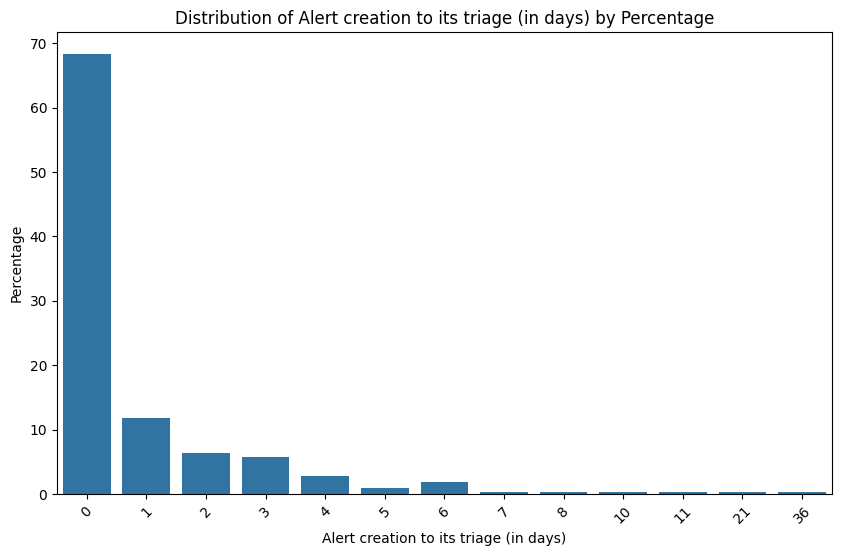

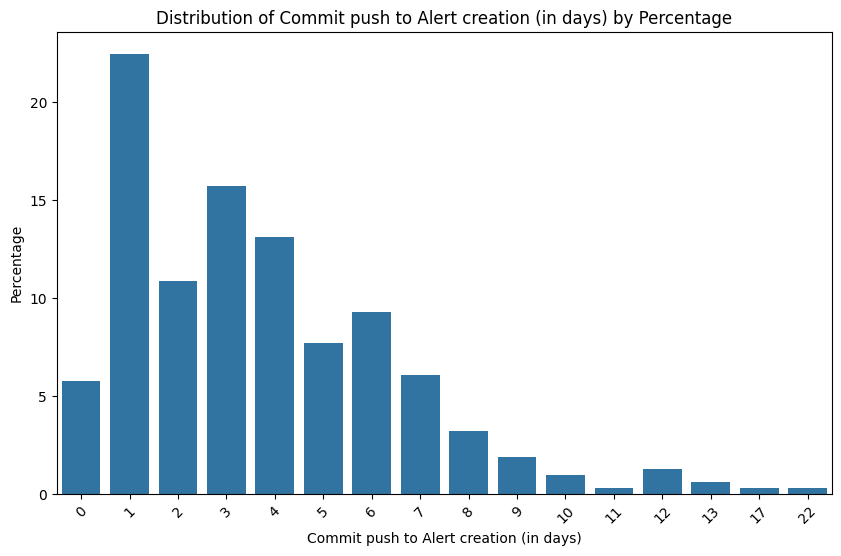

In [ ]:
get_dist_by_perc_modified(df_alerts_bugs, ["delta_alert_creation_to_first_triage", "delta_push_to_alert_creation"])

<ipython-input-155-d110d37ae555>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alerts_bugs[resulting_column] = df_alerts_bugs[resulting_column].apply(convert_to_string)


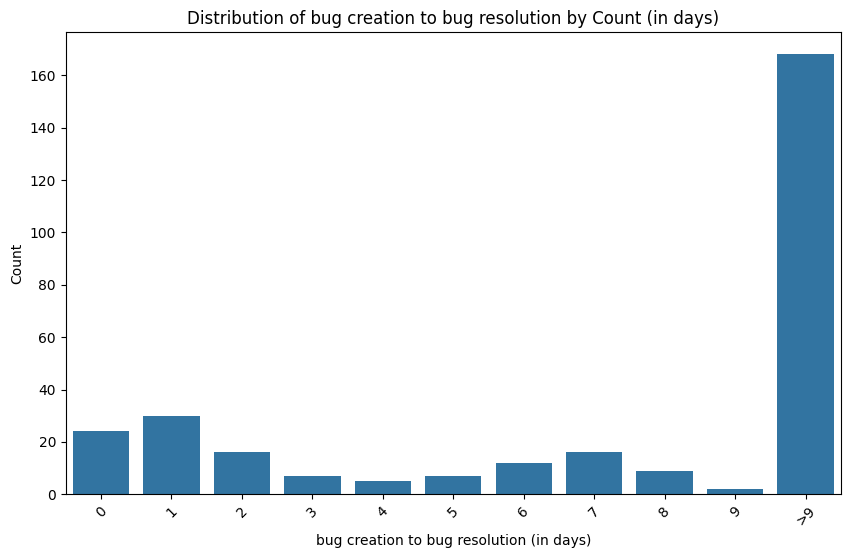

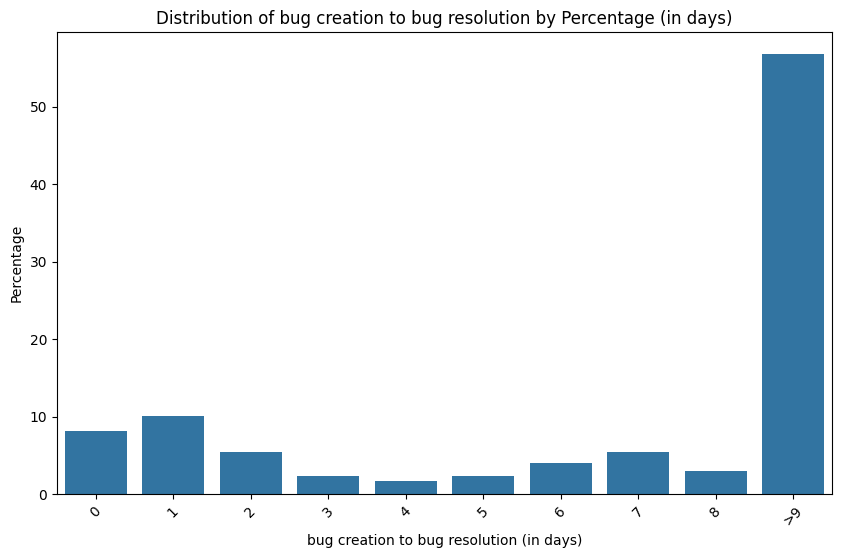

In [ ]:
first_column = "bug_cf_last_resolved"
second_column = "bug_creation_time"
resulting_column = "delta_bug_creation_to_bug_last_resolved"
df_alerts_bugs[resulting_column] = (df_alerts_bugs[first_column] - df_alerts_bugs[second_column]).dt.total_seconds() / (3600 * 24)
df_alerts_bugs[resulting_column] = pd.to_numeric(df_alerts_bugs[resulting_column], errors='coerce')
df_alerts_bugs[resulting_column] = df_alerts_bugs[resulting_column].where(df_alerts_bugs[resulting_column].notna() & df_alerts_bugs[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
df_alerts_bugs[resulting_column] = df_alerts_bugs[resulting_column].apply(lambda x: int(x) if pd.notna(x) else np.nan)
df_alerts_bugs[resulting_column] = pd.to_numeric(df_alerts_bugs[resulting_column], errors='coerce').fillna(np.nan).astype('Int64')
df_alerts_bugs = df_alerts_bugs.dropna(subset=[resulting_column])
def convert_to_string(x):
    if x < 10:
        return str(x)
    else:
        return ">9"
# Apply the custom function to each element in the DataFrame
df_alerts_bugs[resulting_column] = df_alerts_bugs[resulting_column].apply(convert_to_string)


order = sorted(set(df_alerts_bugs[resulting_column]), key=lambda x: (x == ">9", x))
plt.figure(figsize=(10, 6))
sns.countplot(data=df_alerts_bugs, x=resulting_column, order=order)
plt.title(f'Distribution of bug creation to bug resolution by Count (in days)')
plt.ylabel('Count')
plt.xlabel('bug creation to bug resolution (in days)')
plt.xticks(rotation=45)
plt.show()
percentages = df_alerts_bugs[resulting_column].value_counts(normalize=True).reindex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '>9']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=percentages.index, y=percentages.values, order=['0', '1', '2', '3', '4', '5', '6', '7', '8', '>9'])
plt.title(f'Distribution of bug creation to bug resolution by Percentage (in days)')
plt.ylabel('Percentage')
plt.xlabel('bug creation to bug resolution (in days)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
timeseries_df = pd.read_csv('/content/timeseries_data.csv', index_col=False).drop_duplicates()
timeseries_df["push_timestamp"] = pd.to_datetime(timeseries_df["push_timestamp"], format='%Y-%m-%dT%H:%M:%S')
'''df1 = pd.read_csv('/content/4768977_timeseries_data.csv')
df2 = pd.read_csv('/content/4768979_timeseries_data.csv')
df3 = pd.read_csv('/content/4768980_timeseries_data.csv')
df4 = pd.read_csv('/content/4769032_timeseries_data.csv')
sample_timeseries_df = pd.concat([df1, df2, df3, df4], ignore_index=True).drop_duplicates()
sample_timeseries_df["push_timestamp"] = pd.to_datetime(sample_timeseries_df["push_timestamp"], format='%Y-%m-%dT%H:%M:%S')'''

<ipython-input-156-f6413595350c>:1: DtypeWarning: Columns (5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.
  timeseries_df = pd.read_csv('/content/timeseries_data.csv', index_col=False).drop_duplicates()


'df1 = pd.read_csv(\'/content/4768977_timeseries_data.csv\')\ndf2 = pd.read_csv(\'/content/4768979_timeseries_data.csv\')\ndf3 = pd.read_csv(\'/content/4768980_timeseries_data.csv\')\ndf4 = pd.read_csv(\'/content/4769032_timeseries_data.csv\')\nsample_timeseries_df = pd.concat([df1, df2, df3, df4], ignore_index=True).drop_duplicates()\nsample_timeseries_df["push_timestamp"] = pd.to_datetime(sample_timeseries_df["push_timestamp"], format=\'%Y-%m-%dT%H:%M:%S\')'

In [ ]:
df.rename(columns={'test_series_signature_id': 'signature_id'}, inplace=True)

In [ ]:
df_alerts_timeseries = pd.merge(timeseries_df, df, on='signature_id', how='inner')

In [ ]:
display(df.head(4))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0       139        1423417             1423368 2024-05-08 17:54:23.264764   
1       138        1423277             1423269 2024-05-08 17:24:58.063351   
2       137        1423124             1423077 2024-05-08 16:31:27.262251   
3       137        1423124             1423077 2024-05-08 16:31:27.262251   

  alert_first_triaged      alert_triage_due_date alert_repository  \
0                 NaT 2024-05-13 17:54:23.264764         autoland   
1                 NaT 2024-05-13 17:24:58.063351         autoland   
2                 NaT 2024-05-13 16:31:27.262251         autoland   
3                 NaT 2024-05-13 16:31:27.262251         autoland   

       alert_framework  test_id test_status  signature_id  \
0  platform_microbench      496   untriaged       4662919   
1  platform_microbench      495   untriaged       3482492   
2  platform_microbench      493   untriaged       3482392   
3  platform_microbench      494   untriaged       4662915   

       test_series_signature_signature_hash  \
0  2886a3d67e6faeb4aa8d2d13860caae4a5ab1a4d   
1  3f826ce9164041044ad62bd80940c584561f1a19   
2  77060156e1ae922a978c99ce35068106eb40749e   
3  2606d85e165765a20f96a4e2f1d8b2990a4c721a   

  test_series_signature_machine_platform test_series_signature_test  \
0                   windows11-32-2009-qr         PerfStripCharsCRLF   
1                       macosx1015-64-qr  PerfUTF8toUTF16KOThousand   
2                       macosx1015-64-qr          PerfIsUTF8Hundred   
3                   windows11-32-2009-qr        PerfStripWhitespace   

  test_series_signature_suite  test_series_signature_lower_is_better  \
0                     Strings                                   True   
1                     Strings                                   True   
2                     Strings                                   True   
3                     Strings                                   True   

   test_series_signature_has_subtests  \
0                               False   
1                               False   
2                               False   
3                               False   

  test_series_signature_option_collection_hash test_series_signature_tags  \
0     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
1     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
2     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
3     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   

  test_series_signature_extra_options test_series_signature_measurement_unit  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   

   test_series_signature_suite_public_name  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   

   test_series_signature_test_public_name  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   

  test_prev_taskcluster_metadata_task_id  \
0                 QP7M4A4lQ1y93AQ514z7LQ   
1                 DxpIrvXPSFKeXX8cvej11g   
2                 e7Bev2E0S4SHmsXqEeid0A   
3                 UpAqMUYBTtSnbXnhlOD-xw   

   test_prev_taskcluster_metadata_retry_id test_taskcluster_metadata_task_id  \
0                                      0.0            ILQOT39SQomPqLe2F5StxQ   
1                                      0.0            ConJc8EPTqmV-Kg92P3Otg   
2                                      0.0            JA8lSVK3RfWm_wia5nizNA   
3                    

In [ ]:
display(timeseries_df.head(5))

repository_name  signature_id  framework_id  \
0        autoland       4375303            13   
1        autoland       4375303            13   
2        autoland       4375303            13   
3        autoland       4375303            13   
4        autoland       4375303            13   

                             signature_hash  \
0  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
1  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
2  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
3  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
4  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   

                           machine_platform should_alert has_subtests  \
0  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
1  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
2  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
3  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
4  android-hw-a51-11-0-aarch64-shippable-qr         True        False   

   extra_options                           tags  \
0            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
1            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
2            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
3            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
4            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   

                     option_collection_hash                  test  \
0  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
1  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
2  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
3  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
4  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   

                       suite lower_is_better  \
0  google-search-restaurants            True   
1  google-search-restaurants            True   
2  google-search-restaurants            True   
3  google-search-restaurants            True   
4  google-search-restaurants            True   

                                                name  parent_signature  \
0  google-search-restaurants ContentfulSpeedIndex...               NaN   
1  google-search-restaurants ContentfulSpeedIndex...               NaN   
2  google-search-restaurants ContentfulSpeedIndex...               NaN   
3  google-search-restaurants ContentfulSpeedIndex...               NaN   
4  google-search-restaurants ContentfulSpeedIndex...               NaN   

   repository_id measurement_unit application  job_id      entry_id  \
0           77.0               ms   geckoview     NaN  1.696050e+09   
1           77.0               ms   geckoview     NaN  1.696181e+09   
2           77.0               ms   geckoview     NaN  1.696258e+09   
3           77.0               ms   geckoview     NaN  1.696316e+09   
4           77.0               ms   geckoview     NaN  1.696439e+09   

       push_timestamp  value                                  revision  \
0 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
1 2023-05-16 13:31:12  251.0  7abf96264256620bc192d41c79cc916987e914a1   
2 2023-05-16 15:05:08  259.0  2814e09f635a0c47aadae8c3cb5ac25f11fc2559   
3 2023-05-16 16:46:13  251.0  035b9c71b0426a44e2f8cf7ccdcd304300a02e1a   
4 2023-05-16 20:23:59  262.0  099d8db3bdb4ddd321f38c1c4328c7ea2f0cc79a   

     push_id  
0  1241474.0  
1  1241641.0  
2  1241719.0  
3  1241812.0  
4  1241976.0

In [ ]:
def display_sample(dataf, sig_id, date_delta=None):
  #sample_df = df_alerts_timeseries.copy()
  sample_df = dataf.copy()
  sample_df = sample_df[sample_df["signature_id"] == sig_id]
  if date_delta:
    sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
  sample_df.set_index('push_timestamp', inplace=True)
  plt.figure(figsize=(10, 6))
  plt.plot(sample_df.index, sample_df['value'], marker='o', linestyle='-')
  plt.title('Time Series Plot')
  plt.xlabel('Date')
  plt.ylabel('Test measurement values associated with signature ID ' + str(sig_id))
  plt.grid(True)
  plt.show()

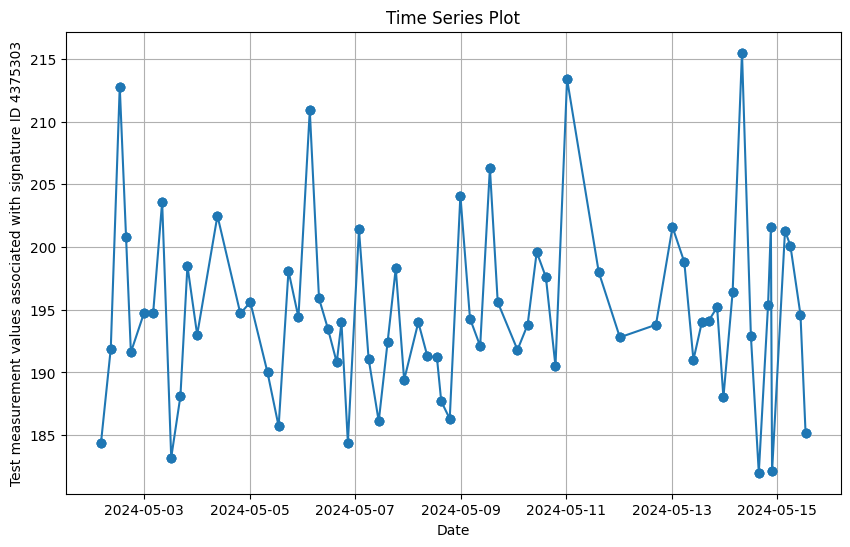

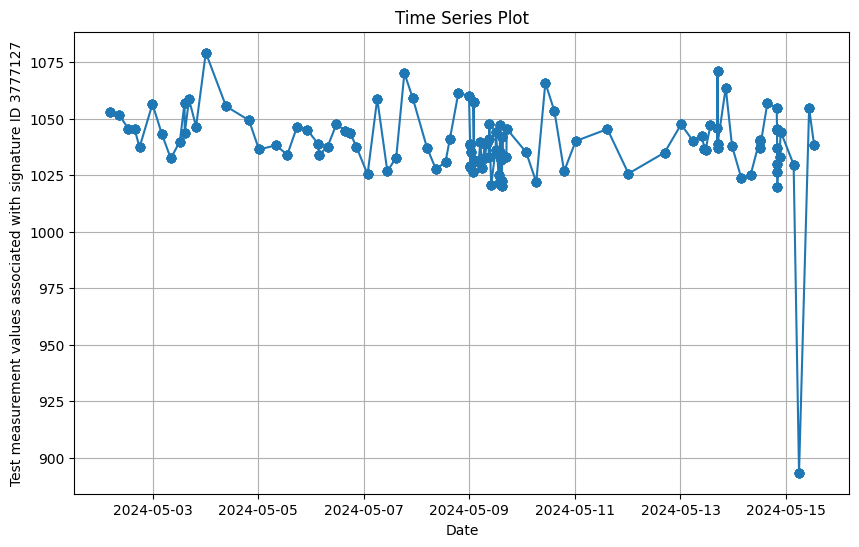

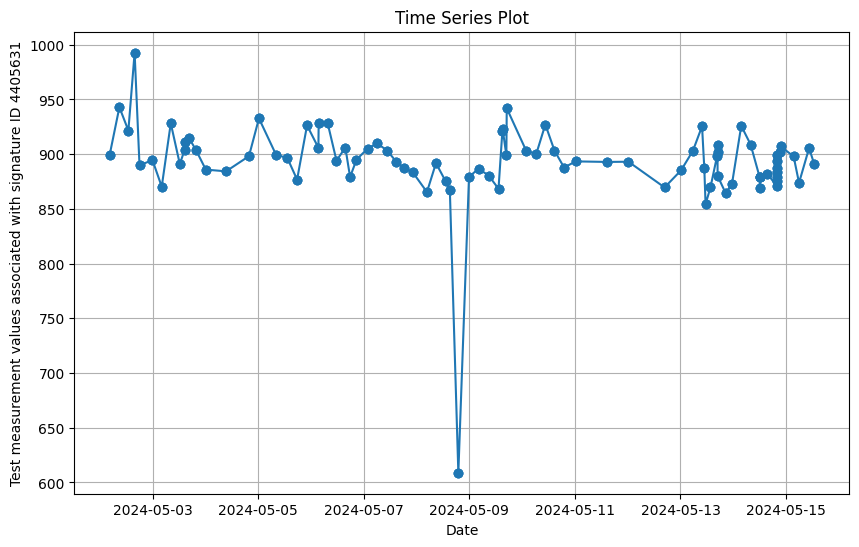

In [ ]:
date_13_days_ago = datetime(2024, 5, 15) - timedelta(days=13)
display_sample(df_alerts_timeseries, 4375303, date_13_days_ago)
display_sample(df_alerts_timeseries, 3777127, date_13_days_ago)
display_sample(df_alerts_timeseries, 4405631, date_13_days_ago)

The values obtained from the API seem to be coherent with what actually exists in the graphs of Treeherder.
The following screenshots from Treeherder are associated with the signature IDs that are plotted in the previous text cell :

4375303 :
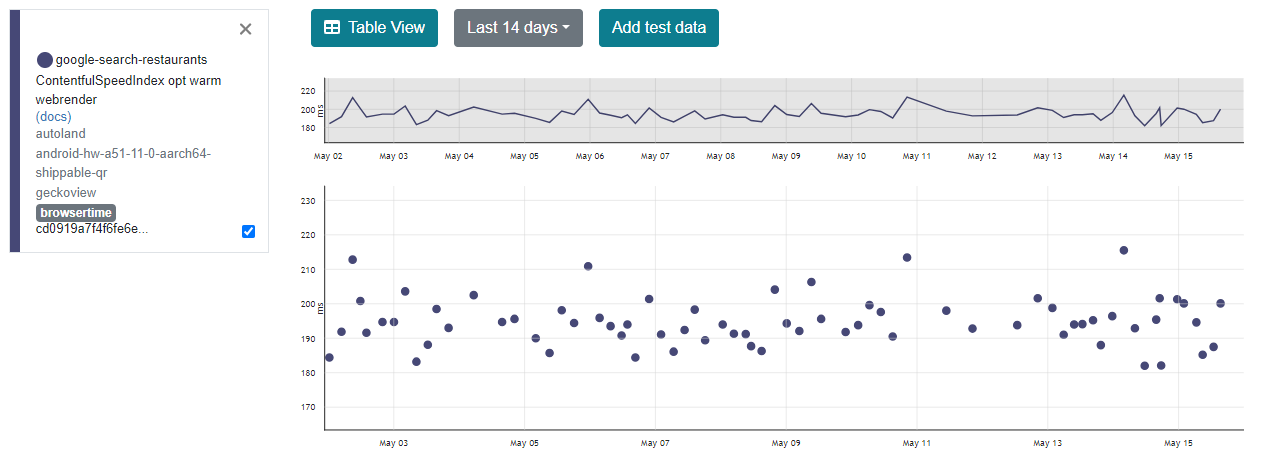
3777127 :
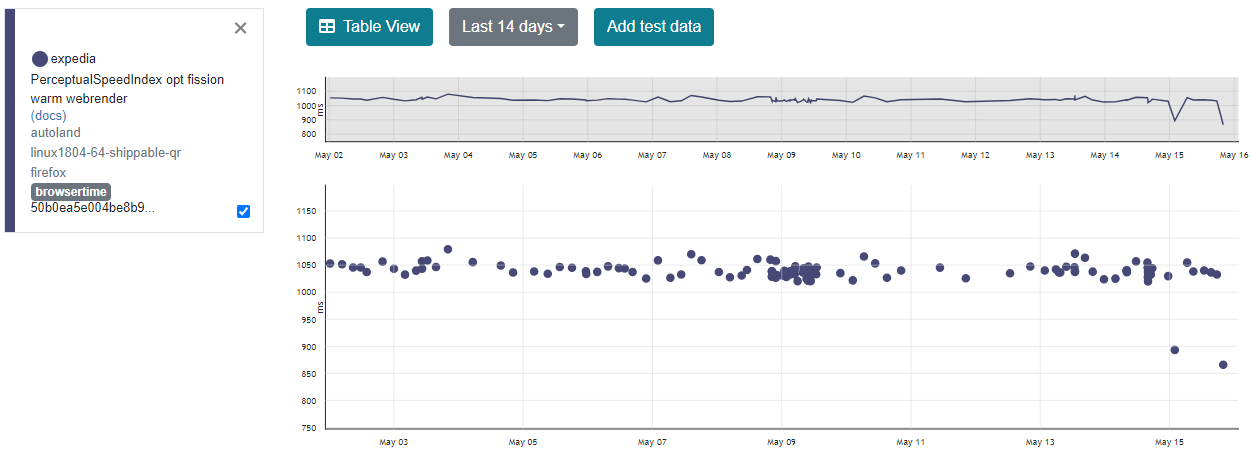
4405631 :
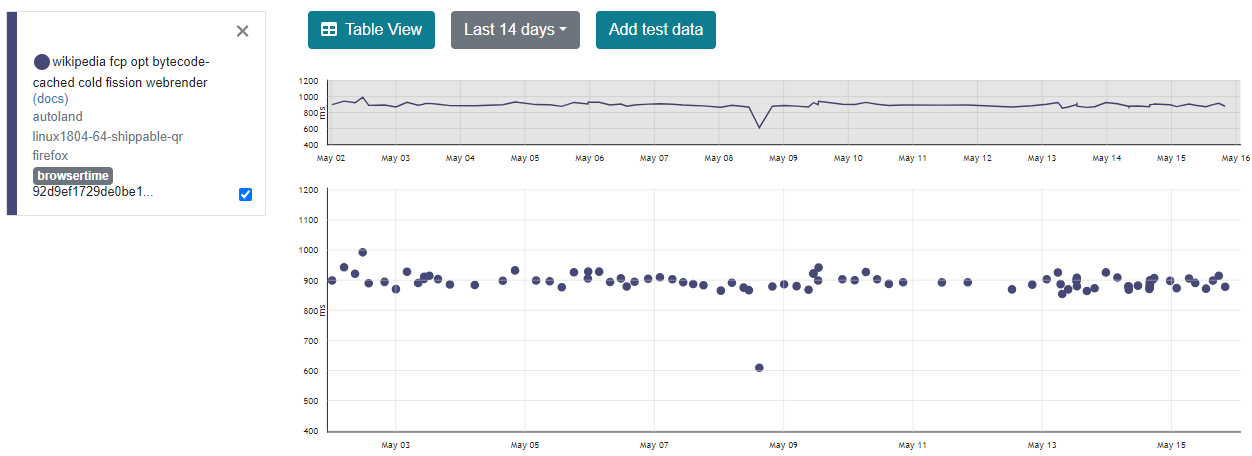


In [ ]:
display(df_alerts_timeseries.head(5))

repository_name  signature_id  framework_id  \
0        autoland       4375303            13   
1        autoland       4375303            13   
2        autoland       4375303            13   
3        autoland       4375303            13   
4        autoland       4375303            13   

                             signature_hash  \
0  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
1  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
2  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
3  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
4  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   

                           machine_platform should_alert has_subtests  \
0  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
1  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
2  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
3  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
4  android-hw-a51-11-0-aarch64-shippable-qr         True        False   

   extra_options                           tags  \
0            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
1            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
2            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
3            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
4            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   

                     option_collection_hash                  test  \
0  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
1  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
2  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
3  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
4  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   

                       suite lower_is_better  \
0  google-search-restaurants            True   
1  google-search-restaurants            True   
2  google-search-restaurants            True   
3  google-search-restaurants            True   
4  google-search-restaurants            True   

                                                name  parent_signature  \
0  google-search-restaurants ContentfulSpeedIndex...               NaN   
1  google-search-restaurants ContentfulSpeedIndex...               NaN   
2  google-search-restaurants ContentfulSpeedIndex...               NaN   
3  google-search-restaurants ContentfulSpeedIndex...               NaN   
4  google-search-restaurants ContentfulSpeedIndex...               NaN   

   repository_id measurement_unit application  job_id      entry_id  \
0           77.0               ms   geckoview     NaN  1.696050e+09   
1           77.0               ms   geckoview     NaN  1.696050e+09   
2           77.0               ms   geckoview     NaN  1.696050e+09   
3           77.0               ms   geckoview     NaN  1.696181e+09   
4           77.0               ms   geckoview     NaN  1.696181e+09   

       push_timestamp  value                                  revision  \
0 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
1 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
2 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
3 2023-05-16 13:31:12  251.0  7abf96264256620bc192d41c79cc916987e914a1   
4 2023-05-16 13:31:12  251.0  7abf96264256620bc192d41c79cc916987e914a1   

     push_id  alert_id  alert_push_id  alert_prev_push_id  \
0  1241474.0     40505        1340716             1340541   
1  1241474.0     40315        1331857             1331854   
2  1241474.0     38829        1260515             1260512   
3  1241641.0     40505        1340716             1340541   
4  1241641.0     40315        1331857             1331854   

    alert_creation_timestamp        alert_first_triaged  \
0 2023-12-02 17:51:13.043563 2023-12-04 13:42:02.479087   
1 2023-11-21 14:19:30.367925 2023-11-21 16:00:05.974429   
2 2023-06-22 09:50:16.779070 2023-06-26 07:51:37.260678   
3 2023-12-02 17:51:13.043563 2023-12-04 13:42:02.47908

As no documentation is provided on the columns, it is speculated that should_alert column stand for whether the metrics values associated with rows having should_alert equal to True should be reported through an alert or whether the should_alert attribute is associated with the given signature ID meaning that whether that signature is used for alerts reporting or not. If the second assumption holds, there should be no False entries in the should_alert column and a given signature ID cannot have two associated unique values of should_alert

In [ ]:
'''grouped = df_alerts_timeseries.groupby('signature_id')['should_alert'].nunique()
filtered_groups = grouped[grouped > 2]
unique_elements_column1 = filtered_groups.index.tolist()
print("Number of signature IDs having more than one unique associated value for the should_alert column")
print(len(unique_elements_column1))'''

'grouped = df_alerts_timeseries.groupby(\'signature_id\')[\'should_alert\'].nunique()\nfiltered_groups = grouped[grouped > 2]\nunique_elements_column1 = filtered_groups.index.tolist()\nprint("Number of signature IDs having more than one unique associated value for the should_alert column")\nprint(len(unique_elements_column1))'

In [ ]:
'''print("Unique values in the should_alert column")
print(df_alerts_timeseries["should_alert"].unique())'''

'print("Unique values in the should_alert column")\nprint(df_alerts_timeseries["should_alert"].unique())'

It seems that the second assumption holds although the nan value is suspicious

In [ ]:
print(df_alerts_timeseries.shape)

(2445065, 84)


In [ ]:
print(timeseries_df.shape)
print(df_alerts_timeseries.shape)

(365451, 24)
(2445065, 84)


In [ ]:
print(timeseries_df['signature_id'].unique().shape)

(116,)


In [ ]:
display(timeseries_df.head(5))

repository_name  signature_id  framework_id  \
0        autoland       4375303            13   
1        autoland       4375303            13   
2        autoland       4375303            13   
3        autoland       4375303            13   
4        autoland       4375303            13   

                             signature_hash  \
0  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
1  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
2  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
3  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
4  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   

                           machine_platform should_alert has_subtests  \
0  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
1  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
2  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
3  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
4  android-hw-a51-11-0-aarch64-shippable-qr         True        False   

   extra_options                           tags  \
0            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
1            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
2            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
3            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
4            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   

                     option_collection_hash                  test  \
0  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
1  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
2  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
3  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
4  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   

                       suite lower_is_better  \
0  google-search-restaurants            True   
1  google-search-restaurants            True   
2  google-search-restaurants            True   
3  google-search-restaurants            True   
4  google-search-restaurants            True   

                                                name  parent_signature  \
0  google-search-restaurants ContentfulSpeedIndex...               NaN   
1  google-search-restaurants ContentfulSpeedIndex...               NaN   
2  google-search-restaurants ContentfulSpeedIndex...               NaN   
3  google-search-restaurants ContentfulSpeedIndex...               NaN   
4  google-search-restaurants ContentfulSpeedIndex...               NaN   

   repository_id measurement_unit application  job_id      entry_id  \
0           77.0               ms   geckoview     NaN  1.696050e+09   
1           77.0               ms   geckoview     NaN  1.696181e+09   
2           77.0               ms   geckoview     NaN  1.696258e+09   
3           77.0               ms   geckoview     NaN  1.696316e+09   
4           77.0               ms   geckoview     NaN  1.696439e+09   

       push_timestamp  value                                  revision  \
0 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
1 2023-05-16 13:31:12  251.0  7abf96264256620bc192d41c79cc916987e914a1   
2 2023-05-16 15:05:08  259.0  2814e09f635a0c47aadae8c3cb5ac25f11fc2559   
3 2023-05-16 16:46:13  251.0  035b9c71b0426a44e2f8cf7ccdcd304300a02e1a   
4 2023-05-16 20:23:59  262.0  099d8db3bdb4ddd321f38c1c4328c7ea2f0cc79a   

     push_id  
0  1241474.0  
1  1241641.0  
2  1241719.0  
3  1241812.0  
4  1241976.0

In [ ]:
df_alerts_timeseries = pd.merge(timeseries_df, df, on='signature_id', how='inner')

In [ ]:
display(df.head(5))

alert_id  alert_push_id  alert_prev_push_id   alert_creation_timestamp  \
0       139        1423417             1423368 2024-05-08 17:54:23.264764   
1       138        1423277             1423269 2024-05-08 17:24:58.063351   
2       137        1423124             1423077 2024-05-08 16:31:27.262251   
3       137        1423124             1423077 2024-05-08 16:31:27.262251   
4       136        1421812             1421623 2024-05-08 16:20:10.262939   

  alert_first_triaged      alert_triage_due_date alert_repository  \
0                 NaT 2024-05-13 17:54:23.264764         autoland   
1                 NaT 2024-05-13 17:24:58.063351         autoland   
2                 NaT 2024-05-13 16:31:27.262251         autoland   
3                 NaT 2024-05-13 16:31:27.262251         autoland   
4                 NaT 2024-05-13 16:20:10.262939         autoland   

       alert_framework  test_id test_status  signature_id  \
0  platform_microbench      496   untriaged       4662919   
1  platform_microbench      495   untriaged       3482492   
2  platform_microbench      493   untriaged       3482392   
3  platform_microbench      494   untriaged       4662915   
4          browsertime      492   untriaged       4366731   

       test_series_signature_signature_hash  \
0  2886a3d67e6faeb4aa8d2d13860caae4a5ab1a4d   
1  3f826ce9164041044ad62bd80940c584561f1a19   
2  77060156e1ae922a978c99ce35068106eb40749e   
3  2606d85e165765a20f96a4e2f1d8b2990a4c721a   
4  6deee2184854d4f6c403e4b2f8e3544ccc85faca   

     test_series_signature_machine_platform test_series_signature_test  \
0                      windows11-32-2009-qr         PerfStripCharsCRLF   
1                          macosx1015-64-qr  PerfUTF8toUTF16KOThousand   
2                          macosx1015-64-qr          PerfIsUTF8Hundred   
3                      windows11-32-2009-qr        PerfStripWhitespace   
4  android-hw-a51-11-0-aarch64-shippable-qr           LastVisualChange   

  test_series_signature_suite  test_series_signature_lower_is_better  \
0                     Strings                                   True   
1                     Strings                                   True   
2                     Strings                                   True   
3                     Strings                                   True   
4                        bing                                   True   

   test_series_signature_has_subtests  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   

  test_series_signature_option_collection_hash test_series_signature_tags  \
0     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
1     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
2     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
3     102210fe594ee9b33d82058545b1ed14f4c8206e                        NaN   
4     102210fe594ee9b33d82058545b1ed14f4c8206e            cold, webrender   

  test_series_signature_extra_options test_series_signature_measurement_unit  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   
4                     cold, webrender                                     ms   

   test_series_signature_suite_public_name  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   test_series_signature_test_public_name  \
0                                     NaN   
1                                     N

In [ ]:
def print_unique_entries_count(dataf, unique_entry, col):
  print("Number of unique signatures associated with the " + str(unique_entry) + " value of column " + col)
  if (str(unique_entry) == "nan"):
    print(len(dataf[dataf[col].isnull()]["signature_id"].unique()))
  else:
    print(len(dataf[dataf[col] == unique_entry]["signature_id"].unique()))

In [ ]:
for repo in df["alert_repository"].unique():
  print_unique_entries_count(df, repo, "alert_repository")

Number of unique signatures associated with the autoland value of column alert_repository
3927
Number of unique signatures associated with the mozilla-central value of column alert_repository
2
Number of unique signatures associated with the mozilla-beta value of column alert_repository
1804
Number of unique signatures associated with the firefox-android value of column alert_repository
351
Number of unique signatures associated with the mozilla-release value of column alert_repository
1


In [ ]:
for measure_unit in timeseries_df["measurement_unit"].unique():
  print_unique_entries_count(timeseries_df, measure_unit, "measurement_unit")

Number of unique signatures associated with the ms value of column measurement_unit
97
Number of unique signatures associated with the score value of column measurement_unit
1
Number of unique signatures associated with the nan value of column measurement_unit
18
Number of unique signatures associated with the fps value of column measurement_unit
1


In [ ]:
#cols = ["test_prev_value", "test_new_value", "test_t_value", "test_amount_abs", "test_amount_pct"]

In [ ]:
'''df_1 = df.dropna(subset=['alert_revision', 'signature_id']).groupby(['alert_revision'])['signature_id'].nunique()
df_1 = df_1[df_1 > 1]
df_2 = df.dropna(subset=['alert_revision', 'signature_id']).groupby(['signature_id'])['alert_revision'].nunique()
df_2 = df_2[df_2 > 1]
print("One revision (commit) have more than one associated signature :")
print(df_1.shape[0] > 0)
print("One signature have more than one associated revision (commit) :")
print(df_2.shape[0] > 0)


df_1 = timeseries_df.dropna(subset=['revision', 'signature_id']).groupby('signature_id')['revision'].apply(lambda x: x.duplicated().any())
aa = df_1
df_1 = df_1[df_1]
print(df_1.shape[0] > 0)
df_2 = timeseries_df.dropna(subset=['revision', 'signature_id']).groupby('revision')['signature_id'].apply(lambda x: x.duplicated().any())
df_2 = df_2[df_2]
print(df_2.shape[0] > 0)


def find_recurring_values(group):
    value_counts = group['revision'].value_counts()
    recurring_values = value_counts[value_counts > 1]
    return recurring_values
recurring_values_per_group = timeseries_df.groupby('signature_id').apply(find_recurring_values).reset_index()
recurring_values_per_group = recurring_values_per_group[recurring_values_per_group['revision'].notna()]
print("A single commit can be stated in a timeseries (one signature ID) multiple times (leading to different measurements values)")
print(recurring_values_per_group.shape[0] > 1)
'''

'df_1 = df.dropna(subset=[\'alert_revision\', \'signature_id\']).groupby([\'alert_revision\'])[\'signature_id\'].nunique()\ndf_1 = df_1[df_1 > 1]\ndf_2 = df.dropna(subset=[\'alert_revision\', \'signature_id\']).groupby([\'signature_id\'])[\'alert_revision\'].nunique()\ndf_2 = df_2[df_2 > 1]\nprint("One revision (commit) have more than one associated signature :")\nprint(df_1.shape[0] > 0)\nprint("One signature have more than one associated revision (commit) :")\nprint(df_2.shape[0] > 0)\n\n\ndf_1 = timeseries_df.dropna(subset=[\'revision\', \'signature_id\']).groupby(\'signature_id\')[\'revision\'].apply(lambda x: x.duplicated().any())\naa = df_1\ndf_1 = df_1[df_1]\nprint(df_1.shape[0] > 0)\ndf_2 = timeseries_df.dropna(subset=[\'revision\', \'signature_id\']).groupby(\'revision\')[\'signature_id\'].apply(lambda x: x.duplicated().any())\ndf_2 = df_2[df_2]\nprint(df_2.shape[0] > 0)\n\n\ndef find_recurring_values(group):\n    value_counts = group[\'revision\'].value_counts()\n    recurrin

In [ ]:
#df_extract = df[df['signature_id'].isin([4768977, 4768979, 4768980, 4769032])]
df_extract = df.copy()

In [ ]:
df_merged = pd.merge(timeseries_df, df_extract, left_on=['revision', 'signature_id'], right_on=['alert_revision', 'signature_id'], how='left')
df_merged['alert_status'].fillna('TN', inplace=True)

df_final = df_merged.drop_duplicates()
df_final.drop(columns=['alert_revision'], inplace=True)

display(df_final.head(5))

repository_name  signature_id  framework_id  \
0        autoland       4375303            13   
1        autoland       4375303            13   
2        autoland       4375303            13   
3        autoland       4375303            13   
4        autoland       4375303            13   

                             signature_hash  \
0  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
1  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
2  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
3  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   
4  cd0919a7f4f6fe6eb72dba979ffd26b40cf387b1   

                           machine_platform should_alert has_subtests  \
0  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
1  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
2  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
3  android-hw-a51-11-0-aarch64-shippable-qr         True        False   
4  android-hw-a51-11-0-aarch64-shippable-qr         True        False   

   extra_options                           tags  \
0            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
1            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
2            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
3            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   
4            NaN  |w|a|r|m| |w|e|b|r|e|n|d|e|r|   

                     option_collection_hash                  test  \
0  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
1  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
2  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
3  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   
4  102210fe594ee9b33d82058545b1ed14f4c8206e  ContentfulSpeedIndex   

                       suite lower_is_better  \
0  google-search-restaurants            True   
1  google-search-restaurants            True   
2  google-search-restaurants            True   
3  google-search-restaurants            True   
4  google-search-restaurants            True   

                                                name  parent_signature  \
0  google-search-restaurants ContentfulSpeedIndex...               NaN   
1  google-search-restaurants ContentfulSpeedIndex...               NaN   
2  google-search-restaurants ContentfulSpeedIndex...               NaN   
3  google-search-restaurants ContentfulSpeedIndex...               NaN   
4  google-search-restaurants ContentfulSpeedIndex...               NaN   

   repository_id measurement_unit application  job_id      entry_id  \
0           77.0               ms   geckoview     NaN  1.696050e+09   
1           77.0               ms   geckoview     NaN  1.696181e+09   
2           77.0               ms   geckoview     NaN  1.696258e+09   
3           77.0               ms   geckoview     NaN  1.696316e+09   
4           77.0               ms   geckoview     NaN  1.696439e+09   

       push_timestamp  value                                  revision  \
0 2023-05-16 09:22:24  265.0  35c42de01440437bdebf15b8aa1fcdfd35725078   
1 2023-05-16 13:31:12  251.0  7abf96264256620bc192d41c79cc916987e914a1   
2 2023-05-16 15:05:08  259.0  2814e09f635a0c47aadae8c3cb5ac25f11fc2559   
3 2023-05-16 16:46:13  251.0  035b9c71b0426a44e2f8cf7ccdcd304300a02e1a   
4 2023-05-16 20:23:59  262.0  099d8db3bdb4ddd321f38c1c4328c7ea2f0cc79a   

     push_id  alert_id  alert_push_id  alert_prev_push_id  \
0  1241474.0       NaN            NaN                 NaN   
1  1241641.0       NaN            NaN                 NaN   
2  1241719.0       NaN            NaN                 NaN   
3  1241812.0       NaN            NaN                 NaN   
4  1241976.0       NaN            NaN                 NaN   

  alert_creation_timestamp alert_first_triaged alert_triage_due_date  \
0                      NaT                 NaT                   NaT   
1                      NaT                 NaT                   NaT   
2                      NaT                 NaT                   NaT   
3 

In [ ]:
category_mapping = {
    'investigating': 'SP', # 'SP' stands for 'Still Processing'
    'reassigned': 'SP',
    'invalid': 'FP',
    'improvement': 'TP',
    'fixed': 'TP',
    'wontfix': 'FP',
    'untriaged': 'SP',
    'backedout': 'TP'
}
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [ ]:
def display_sample_2(dataf, sig_id, date_delta=None):
    sample_df = dataf.copy()
    #sample_df = sample_df[(sample_df["signature_id"] == sig_id) & (sample_df["alert_status"] != "TN")]
    sample_df = sample_df[sample_df["signature_id"] == sig_id]
    if date_delta:
        sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    sample_df.set_index('push_timestamp', inplace=True)
    plt.figure(figsize=(12, 8))
    color_mapping = {
        'TP': 'green',
        'FP': 'red',
        'SP': 'grey',
        'TN': 'blue'
    }
    for idx, row in sample_df.iterrows():
        plt.plot(idx, row['value'], marker='o', markersize=8, color=color_mapping.get(row['alert_status']), alpha=0.6)
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(f'Test measurement values associated with signature ID {sig_id}')
    plt.grid(True)
    plt.xlim(sample_df.index.min(), sample_df.index.max())
    plt.show()
'''
date_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)
print(4768977)
display_sample_2(df_final, 4768977, date_x_days_ago)

print(4768979)
display_sample_2(df_final, 4768979, date_x_days_ago)

print(4768980)
display_sample_2(df_final, 4768980, date_x_days_ago)

print(4769032)
display_sample_2(df_final, 4769032, date_x_days_ago)'''

'\ndate_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)\nprint(4768977)\ndisplay_sample_2(df_final, 4768977, date_x_days_ago)\n\nprint(4768979)\ndisplay_sample_2(df_final, 4768979, date_x_days_ago)\n\nprint(4768980)\ndisplay_sample_2(df_final, 4768980, date_x_days_ago)\n\nprint(4769032)\ndisplay_sample_2(df_final, 4769032, date_x_days_ago)'

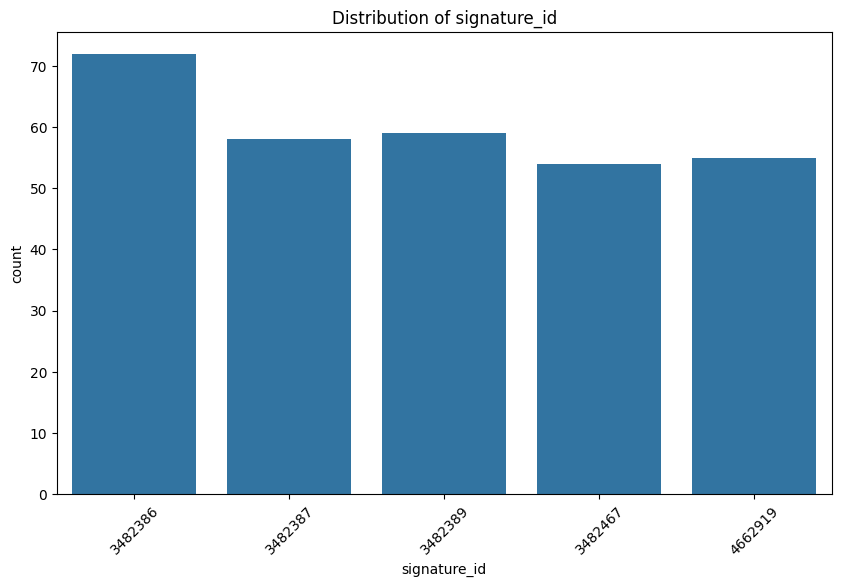

In [ ]:
n = 5
top_n_categories = df['signature_id'].value_counts().nlargest(n).index
filtered_df = df[df['signature_id'].isin(top_n_categories)]
get_dist_by_nb(filtered_df, ['signature_id'])

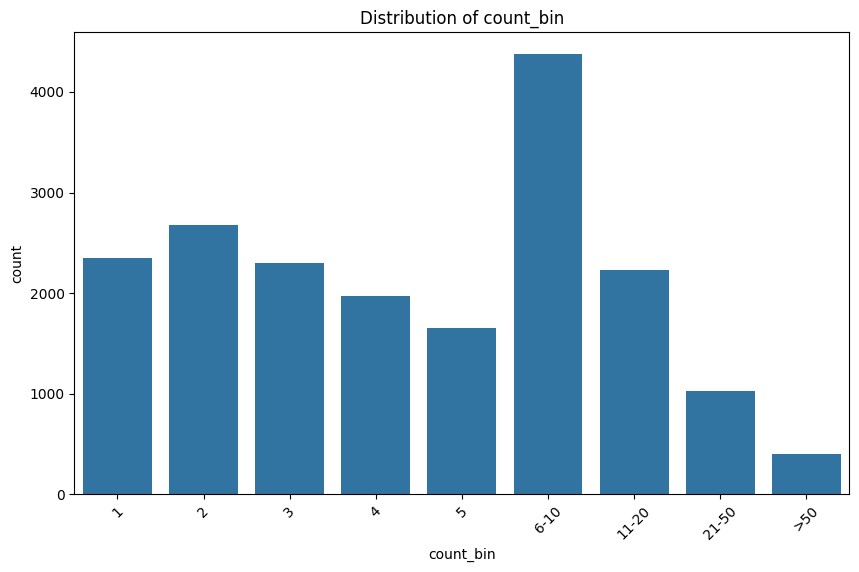

In [ ]:
df_sig_dist = df.copy()
category_counts = df_sig_dist['signature_id'].value_counts()
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3', '4', '5', '6-10', '11-20', '21-50', '>50']
category_bins = pd.cut(category_counts, bins=bins, labels=labels, right=True)
category_bins_df = category_bins.reset_index()
category_bins_df.columns = ['signature_id', 'count_bin']
df_sig_dist = df_sig_dist.merge(category_bins_df, on='signature_id', how='left')
get_dist_by_nb(df_sig_dist, ['count_bin'])

In [ ]:
category_counts = df_sig_dist['signature_id'].value_counts()
average_count = category_counts.mean()
median_count = category_counts.median()
print(f"Signatures average count: {average_count:.2f}")
print(f"Signatures median count: {median_count:.2f}")

Signatures average count: 3.12
Signatures median count: 2.00


In [ ]:
percentage_counts = df_final['alert_status'].value_counts(normalize=True) * 100
print(percentage_counts)

alert_status
TN    99.628952
SP     0.270625
TP     0.064578
FP     0.035846
Name: proportion, dtype: float64


In [ ]:
most_frequent_signatures = [3482386, 3482387, 3482389, 3482467, 4662919]
df1 = pd.read_csv('/content/3482386_timeseries_data.csv')
df2 = pd.read_csv('/content/3482387_timeseries_data.csv')
df3 = pd.read_csv('/content/3482389_timeseries_data.csv')
df4 = pd.read_csv('/content/3482467_timeseries_data.csv')
df5 = pd.read_csv('/content/4662919_timeseries_data.csv')
df6 = pd.read_csv('/content/3779889_timeseries_data.csv')
df7 = pd.read_csv('/content/3779886_timeseries_data.csv')
df8 = pd.read_csv('/content/3891453_timeseries_data.csv')
df9 = pd.read_csv('/content/2259234_timeseries_data.csv')
df10 = pd.read_csv('/content/2680290_timeseries_data.csv')
df11 = pd.read_csv('/content/4669835_timeseries_data.csv')
sample_timeseries_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True).drop_duplicates()
sample_timeseries_df["push_timestamp"] = pd.to_datetime(sample_timeseries_df["push_timestamp"], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
sample_timeseries_df_merged = pd.merge(sample_timeseries_df, df_extract, left_on=['revision', 'signature_id'], right_on=['alert_revision', 'signature_id'], how='left')
sample_timeseries_df_merged['alert_status'].fillna('TN', inplace=True)

sample_df_final = sample_timeseries_df_merged.drop_duplicates()
sample_df_final.drop(columns=['alert_revision'], inplace=True)

category_mapping = {
    'investigating': 'SP', # 'SP' stands for 'Still Processing'
    'reassigned': 'SP',
    'invalid': 'FP',
    'improvement': 'TP',
    'fixed': 'TP',
    'wontfix': 'FP',
    'untriaged': 'SP',
    'backedout': 'TP'
}
sample_df_final["alert_status"] = sample_df_final["alert_status"].replace(category_mapping)

In [ ]:
date_one_year_ago = datetime(2024, 5, 15) - timedelta(days=365)
def display_sig_characteristics(sig_id):
  display_sample_2(sample_df_final, sig_id, date_one_year_ago)
  subject_sig_df = sample_df_final[sample_df_final['signature_id'] == sig_id]
  percentage_counts = subject_sig_df['alert_status'].value_counts(normalize=True) * 100
  print(percentage_counts)

characteristics of signature ID 3482386


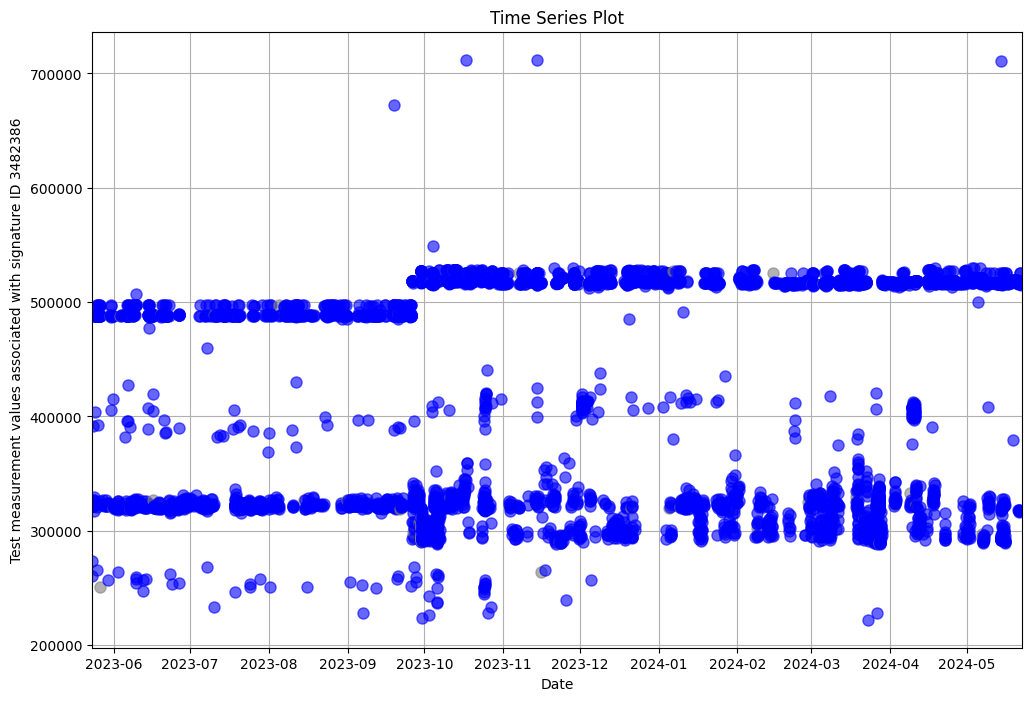

alert_status
TN    97.931539
SP     2.068461
Name: proportion, dtype: float64
characteristics of signature ID 3482387


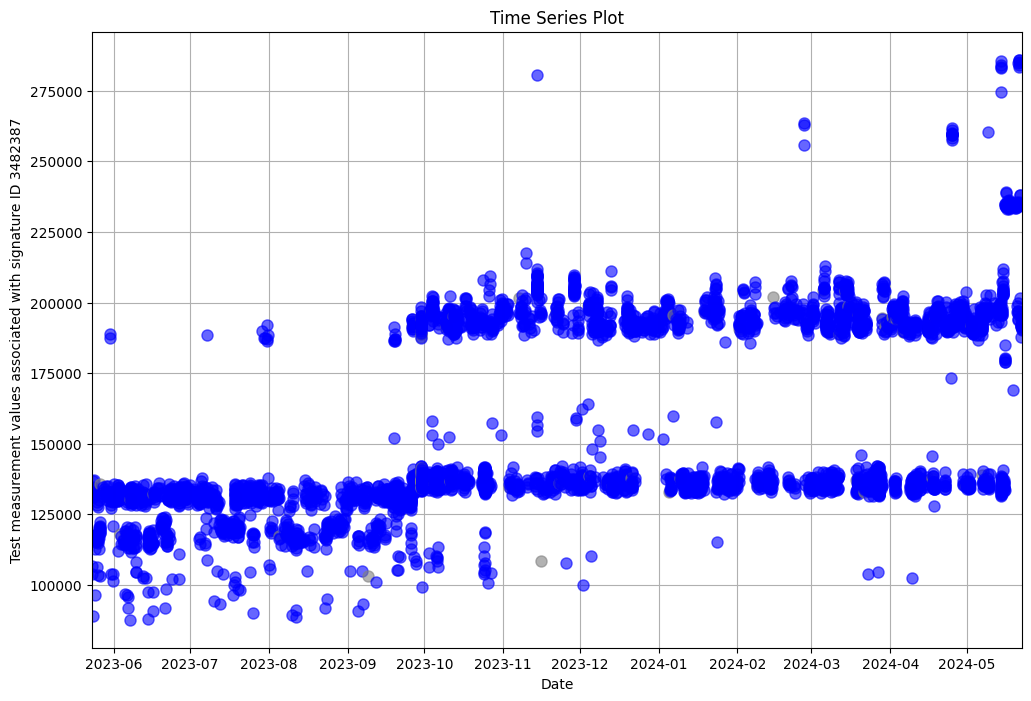

alert_status
TN    98.370859
SP     1.629141
Name: proportion, dtype: float64
characteristics of signature ID 3482389


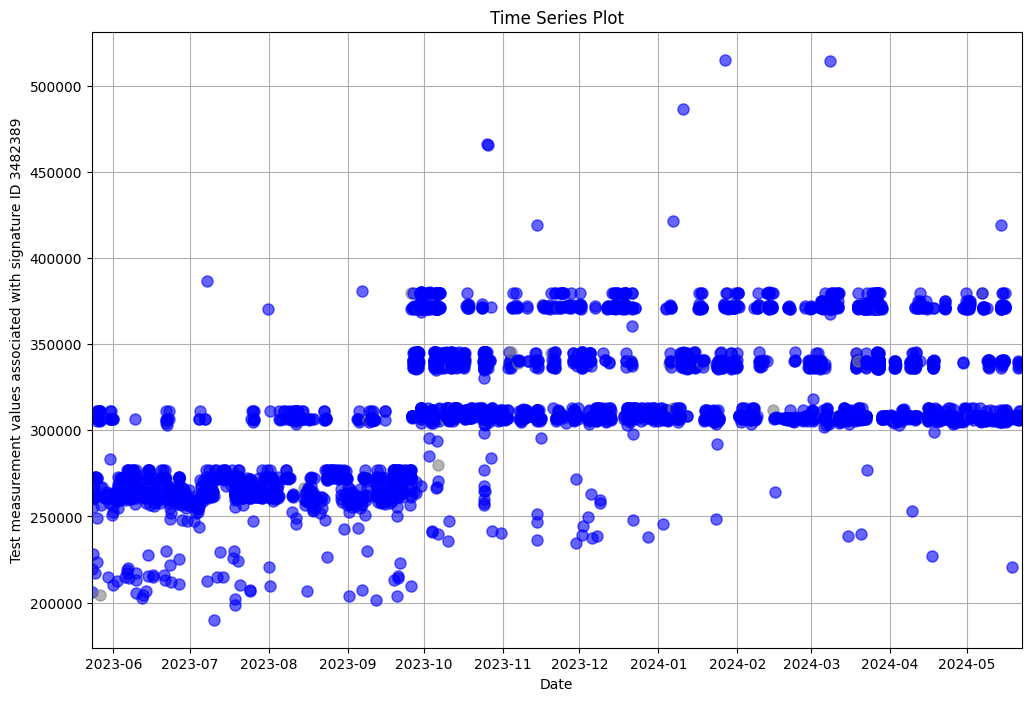

alert_status
TN    98.261029
SP     1.738971
Name: proportion, dtype: float64
characteristics of signature ID 3482467


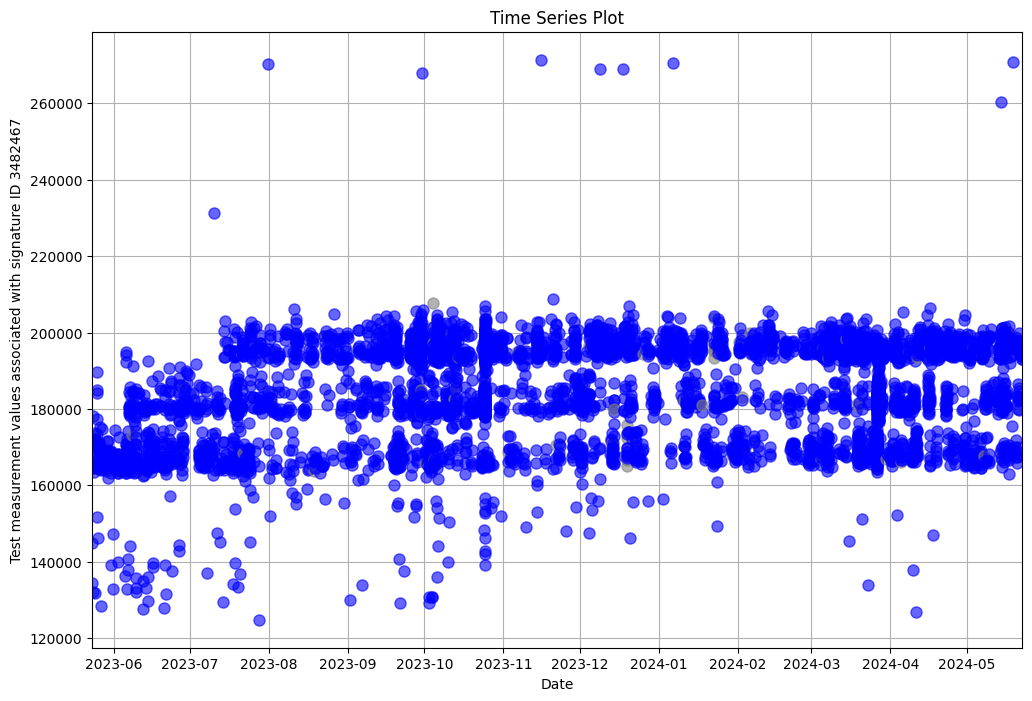

alert_status
TN    98.682284
SP     1.317716
Name: proportion, dtype: float64
characteristics of signature ID 4662919


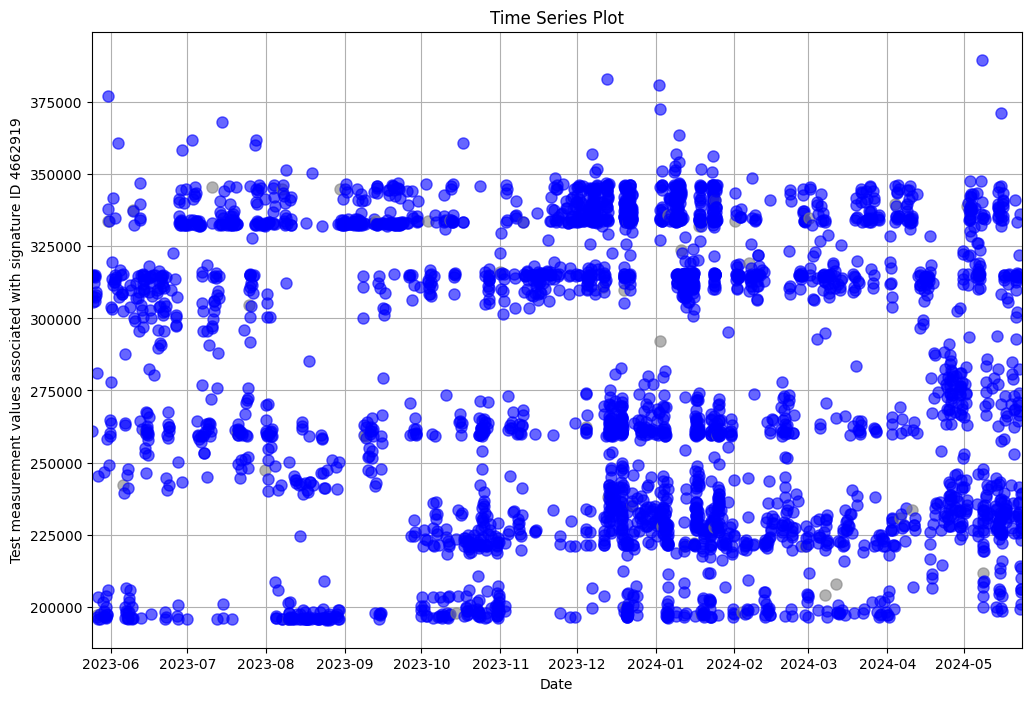

alert_status
TN    98.45079
SP     1.54921
Name: proportion, dtype: float64


In [ ]:
for sig in most_frequent_signatures:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

In [ ]:
filtered_df = df[df['alert_status'].isin(["backedout", "fixed", "improvement"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_tp_sig = [3779889, 3779886, 3891453]

signature_id
3779889    11
3779886    10
3891453    10
Name: count, dtype: int64


characteristics of signature ID 3779889


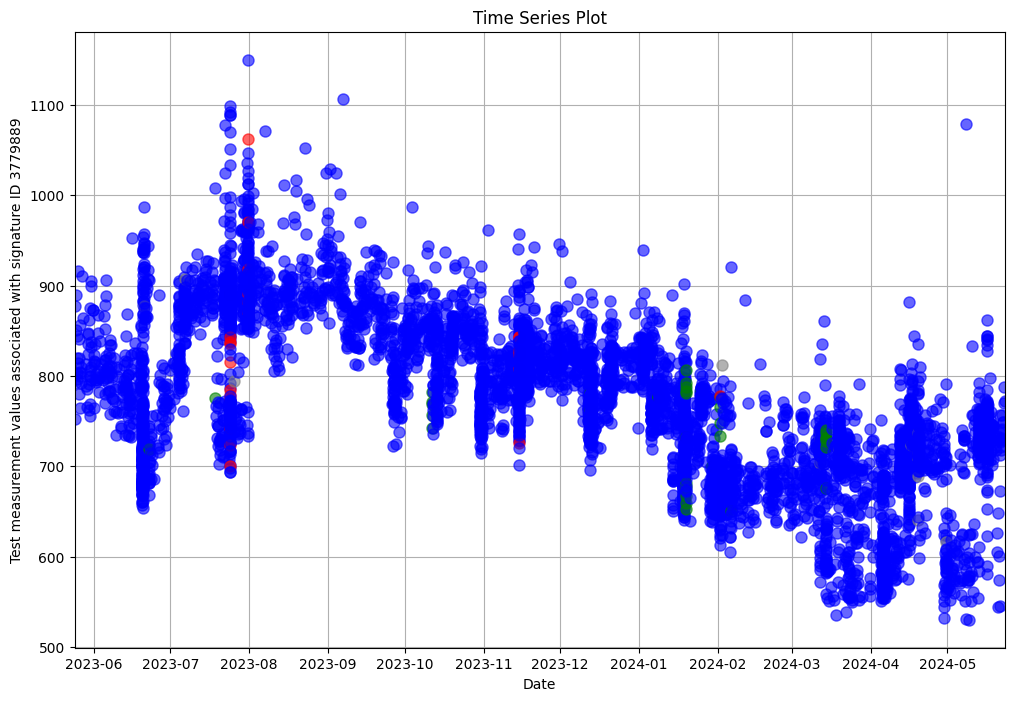

alert_status
TN    98.662093
TP     0.617496
FP     0.445969
SP     0.274443
Name: proportion, dtype: float64
characteristics of signature ID 3779886


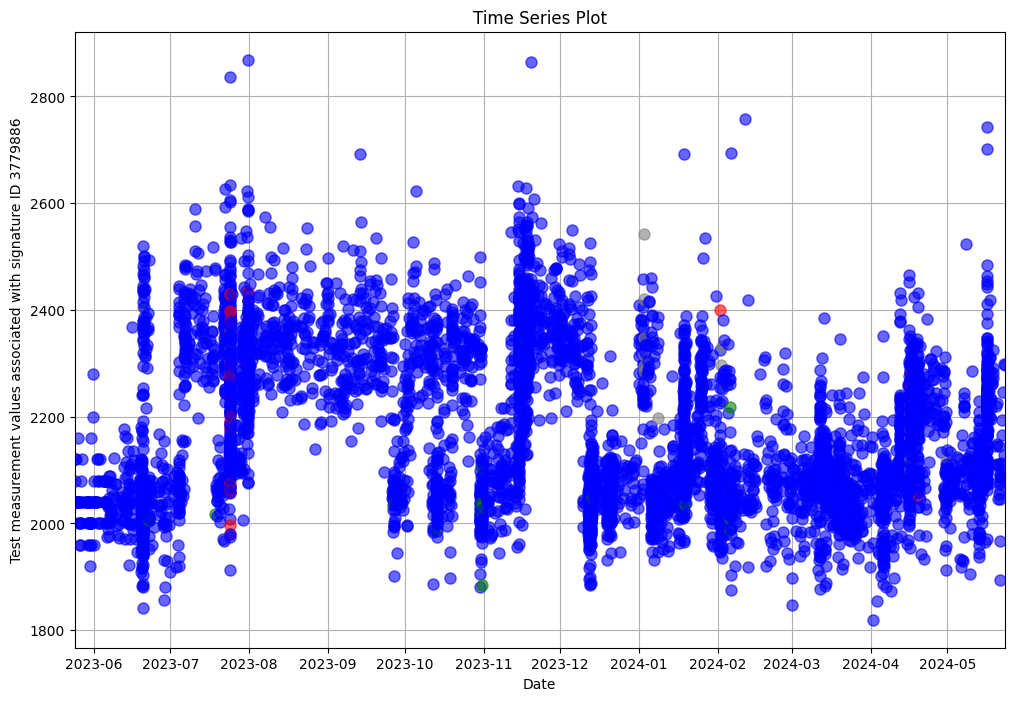

alert_status
TN    98.610635
FP     0.548885
SP     0.463122
TP     0.377358
Name: proportion, dtype: float64
characteristics of signature ID 3891453


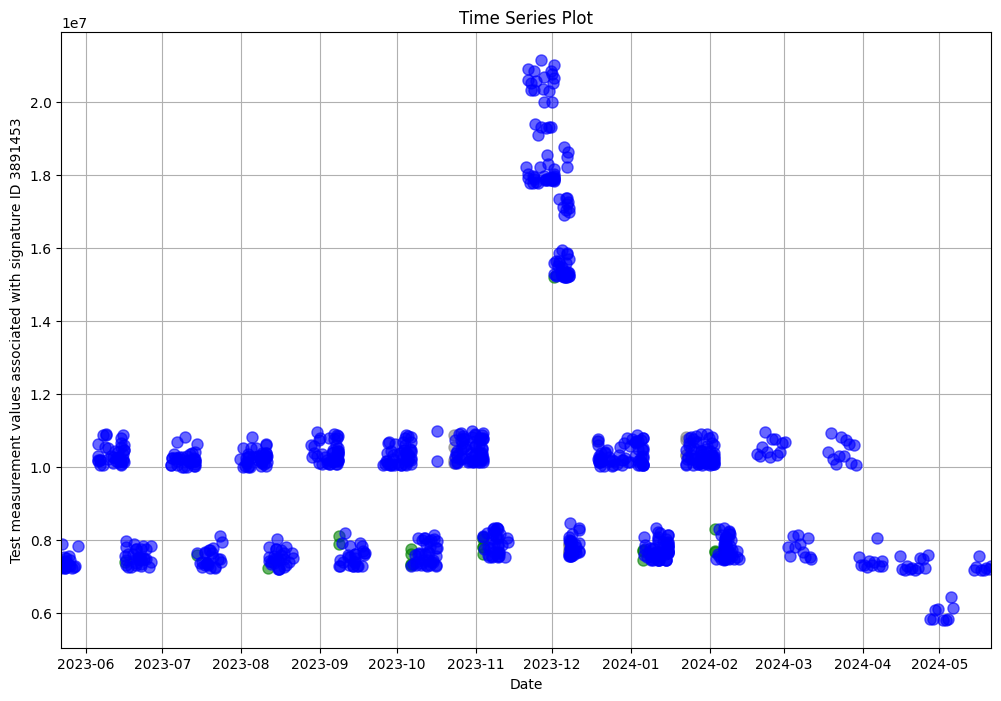

alert_status
TN    96.153846
TP     2.243590
SP     1.602564
Name: proportion, dtype: float64


In [ ]:
for sig in top_tp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

In [ ]:
filtered_df = df[df['alert_status'].isin(["wontfix", "invalid"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_fp_sig = [2259234, 2680290, 4669835]

signature_id
2259234    30
2680290    19
4669835    17
Name: count, dtype: int64


characteristics of signature ID 2259234


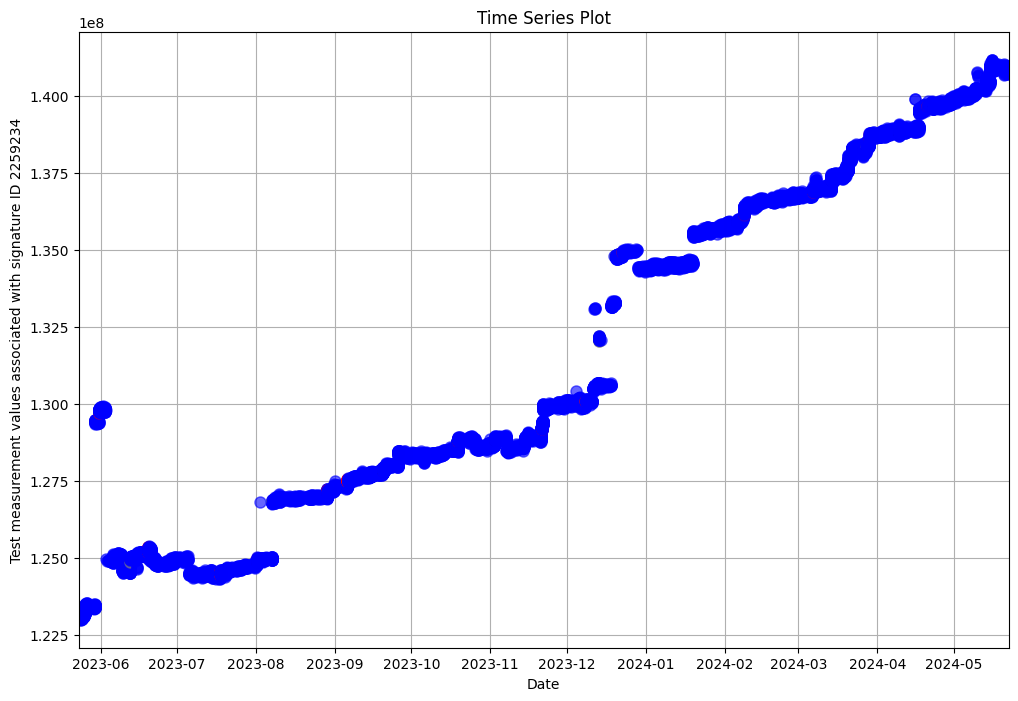

alert_status
TN    99.076228
FP     0.663747
SP     0.239496
TP     0.020528
Name: proportion, dtype: float64
characteristics of signature ID 2680290


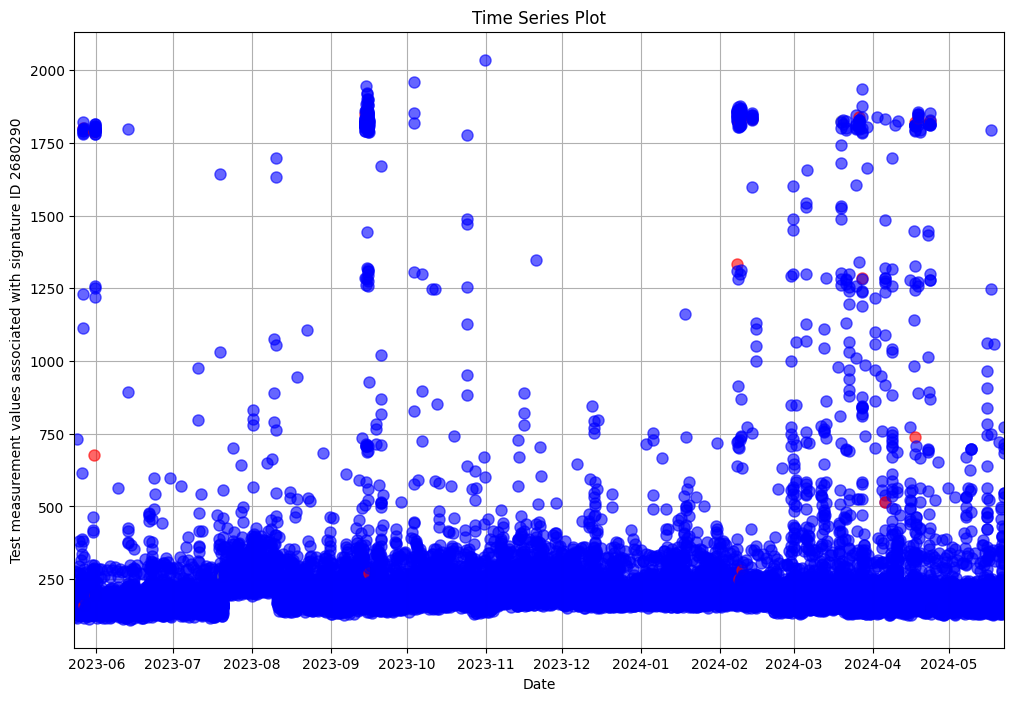

alert_status
TN    99.903985
FP     0.087287
SP     0.008729
Name: proportion, dtype: float64
characteristics of signature ID 4669835


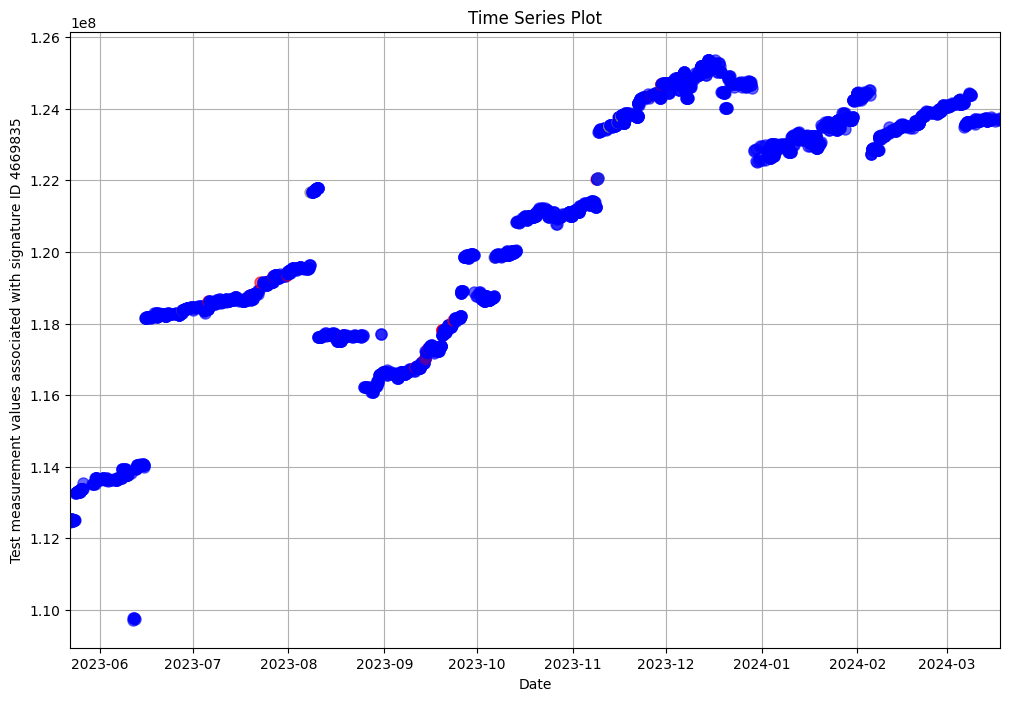

alert_status
TN    98.121713
FP     1.051841
SP     0.788881
TP     0.037566
Name: proportion, dtype: float64


In [ ]:
for sig in top_fp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)